### Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchmetrics.image.fid import FrechetInceptionDistance
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns
import wandb

### Set Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


In [3]:
saved_model_folder = "./saved_models"
os.makedirs(saved_model_folder, exist_ok=True)

### Data Loading and Processing

In [4]:
class AFHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: path of the parent directory that contains images.
        transforms: augmentations applied to the images (can be none or more).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_mapping = {}
        
        extensions = (".jpg", ".jpeg", ".png")
        # go through all sub-directories
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            full_path = os.path.join(root_dir, category)
            if os.path.exists(full_path):
                self.class_mapping[label] = category
                for img_name in os.listdir(full_path):
                    if img_name.endswith(extensions):
                        self.image_paths.append(os.path.join(full_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
# Dataset Hyperparameters
img_size = 64
batch_size = 64

# dataset paths
train_dir = 'data/afhq/train'
val_dir = 'data/afhq/val'

### Define augmentations

In [6]:
transform = transforms.Compose([
    
        # transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.Resize((img_size, img_size)), # image is downsampled to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [7]:
# Load the train and val dataset
train_dataset = AFHQDataset(root_dir=train_dir, transform=transform)
val_dataset = AFHQDataset(root_dir=val_dir, transform=transform)

# DataLoaders for train and val sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)

print(f"Train dataset size: {train_size}")
print(f"Validation dataset size: {val_size}")

Train dataset size: 14630
Validation dataset size: 1500


### Visualize Dataset

In [8]:
def visualize_dataset(dataloader, num_images=12):
    """
    Visualizes a given number of images from the given data loader.
    """
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    class_mapping = dataloader.dataset.class_mapping
    
    # creates a suitable grid
    # grid_size = int(np.ceil(np.sqrt(num_images)))
    num_rows = int(np.sqrt(num_images))
    num_cols = int(np.ceil(num_images / num_rows))
    # print(num_cols, num_rows)
    plt.figure(figsize=(6, 6))
    plt.suptitle("Sample images from AFHQ dataset")
    
    for idx in range(min(num_images, len(images))):
        plt.subplot(num_rows, num_cols, idx + 1)
        
        img = images[idx].permute(1, 2, 0).numpy()
        max_val = np.max(img)
        min_val = np.min(img)
        img = (img - min_val) / (max_val - min_val)
        
        plt.imshow(img)
        plt.title(f'Class: {class_mapping[labels[idx].item()]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

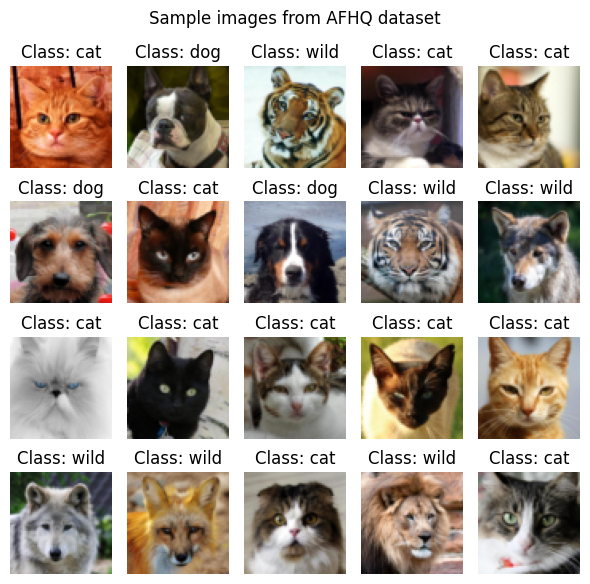

In [9]:
visualize_dataset(train_loader, num_images=20)

### Training and Validation Code

In [17]:
def vae_loss_function(recon_x, x, mu, log_var, kl_weight=1):
    """
    Calculates the VAE loss as a combination of 
    reconstruction loss and KL divergence, 
    scaled by a weight.
    """
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_divergence * kl_weight, recon_loss, kl_divergence

def train_vae(model, train_loader, optimizer, kl_weight, device, num_classes=3):
    """
    Trains the Variational Autoencoder (VAE) for one epoch on the given training data loader.
    """
    model.train()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        one_hot_labels = F.one_hot(labels, num_classes)
        optimizer.zero_grad()
        recon_x, mu, log_var = model(inputs, one_hot_labels)
        loss, recon_loss, kl_loss = vae_loss_function(recon_x, inputs, mu, log_var, kl_weight)
        loss.backward()
        optimizer.step()
        
        # Collect all losses
        running_loss += loss.item()
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
        
    dataset_size = len(train_loader.dataset)
    return {
        'total_loss': running_loss / dataset_size,
        'recon_loss': running_recon_loss / dataset_size,
        'kl_loss': running_kl_loss / dataset_size
    }

def evaluate_vae(model, val_loader, kl_weight, device, num_classes=3):
    """
    Evaluates the Variational Autoencoder (VAE) on the validation dataset after each epoch.
    """
    model.eval()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            one_hot_labels = F.one_hot(labels, num_classes)
            recon_x, mu, log_var = model(inputs, one_hot_labels)
            loss, recon_loss, kl_loss = vae_loss_function(recon_x, inputs, mu, log_var, kl_weight)
            
            # Collect all losses
            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()
            
    dataset_size = len(val_loader.dataset)
    return {
        'total_loss': running_loss / dataset_size,
        'recon_loss': running_recon_loss / dataset_size,
        'kl_loss': running_kl_loss / dataset_size
    }

def run_vae_training(
    model, train_loader, val_loader, device, num_epochs, learning_rate=0.001, 
    project="vae-training", name="vae_run", kl_weight=0.1, step_size=30, gamma=0.1, num_classes=3):

    """Train and evaluate the model for a given number of epochs with W&B logging"""

    print(f"Training Name: {name}")
    print(f"Total num. of Epochs: {num_epochs}")
    print(f"Learning Rate: {learning_rate}")
    print(f"KL Weight used for Loss function: {kl_weight}\n")
    
    # Sample a batch for visualization ( used here to make it same for every epoch)
    inputs, labels = next(iter(train_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    one_hot_labels = F.one_hot(labels, num_classes)
    
    
    # Initialize W&B logging
    wandb.init(project=project, name=name, 
               config={
                   "learning_rate": learning_rate,
                   "num_epochs": num_epochs,
                   "step_size": step_size,
                   "gamma": gamma,
                   "kl_weight": kl_weight
               })
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # Optimizer
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    
    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_metrics = train_vae(model, train_loader, optimizer, kl_weight, device)
        # Evaluate after each epoch
        val_metrics = evaluate_vae(model, val_loader, kl_weight, device)
        
        current_lr = scheduler.get_last_lr()[0]
        scheduler.step()

        # Log images to W&B
        with torch.no_grad():
            # # Sample a small batch for visualization
            # inputs, _ = next(iter(train_loader))
            # inputs = inputs[:32].to(device)
            recon_x, _, _ = model(inputs, one_hot_labels)

            # Normalize and convert to image format
            recon_x = recon_x.view(-1, *inputs.shape[1:])
            recon_grid = make_grid(recon_x.cpu().detach() * 0.5 + 0.5, normalize=True, pad_value=1, padding=10)
            original_grid = make_grid(inputs.cpu().detach() * 0.5 + 0.5, normalize=True, pad_value=1, padding=10)
    
        # Log all data to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train/total_loss": train_metrics['total_loss'],
            "train/recon_loss": train_metrics['recon_loss'],
            "train/kl_loss": train_metrics['kl_loss'],
            "val/total_loss": val_metrics['total_loss'],
            "val/recon_loss": val_metrics['recon_loss'],
            "val/kl_loss": val_metrics['kl_loss'],
            "learning_rate": current_lr,
            "original_images": wandb.Image(original_grid),
            "reconstructed_images": wandb.Image(recon_grid),
        })
        
        # # Print stats after each epoch
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Learning Rate: {current_lr:.6f}")
        print(f"Train - Total: {train_metrics['total_loss']:.4f}, "
              f"Recon: {train_metrics['recon_loss']:.4f}, "
              f"KL: {train_metrics['kl_loss']:.4f}")
        print(f"Eval  - Total: {val_metrics['total_loss']:.4f}, "
              f"Recon: {val_metrics['recon_loss']:.4f}, "
              f"KL: {val_metrics['kl_loss']:.4f}")
    
    # End W&B run
    wandb.finish()
    
    return model

### FID Score

In [27]:
def compute_fid_score(model, data_loader, device, max_samples=1000, num_classes=3):
    """
    Computes the Fréchet Inception Distance (FID) between real and generated data.
    Taken from : https://lightning.ai/docs/torchmetrics/stable/image/frechet_inception_distance.html
    """
    fid = FrechetInceptionDistance(feature=2048).to(device)  # Use InceptionV3(default) features
    model.eval()
    
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            one_hot_labels = F.one_hot(labels, num_classes)

            # Generate reconstructions
            recon_x, _, _ = model(inputs, one_hot_labels)

            # Convert images to uint8 and scale to [0, 255]
            inputs = (inputs * 255).byte()  
            recon_x = (recon_x * 255).byte()

            fid.update(inputs, real=True)
            fid.update(recon_x, real=False)

            total_samples += inputs.size(0)
    
    # Compute the FID score
    fid_score = fid.compute().item()
    return fid_score

#### Load saved model

In [28]:
def load_model(model_path):
    """
    Load a saved model
    """
    model = torch.load(model_path)
    return model

### Result visualizations

In [80]:
def visualize_reconstructions(model, device, loader, num_images=5, num_classes=3):
    """Visualizes original and reconstructed images from the VAE"""
    model.eval()

    recon_images = []
    
    for i in range(3):
        with torch.no_grad():
            one_hot_label = F.one_hot(torch.tensor([i]), num_classes)
            one_hot_label = one_hot_label.to(device)
            recon_images.append(model.sample(num_images, one_hot_label, device).cpu().permute(0, 2, 3, 1).numpy())
    recon_images = np.vstack((recon_images[0], recon_images[1], recon_images[2]))
    # min-max normalization
    recon_images = np.array([(img - np.min(img))/(np.max(img) - np.min(img)) for img in recon_images])
    class_mapping = loader.dataset.class_mapping
    
    
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    plt.suptitle("Sample images from Conditional Input")

    clazz = 0
    for idx in range(num_images*num_classes):
        img = recon_images[idx]
        axes[idx].imshow(img)
        axes[idx].set_title(f'Class: {class_mapping[int(idx/5)]}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

### Model Architecture

In [21]:
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAEEncoder, self).__init__()
        
        # Initial convolution
        self.conv_initial = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        
        # Downsampling blocks
        self.conv1 = nn.Conv2d(64, 128, 4, stride=2, padding=1)    # 64x64 -> 32x32
        self.conv2 = nn.Conv2d(128, 256, 4, stride=2, padding=1)   # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(256, 512, 4, stride=2, padding=1)   # 16x16 -> 8x8
        self.conv4 = nn.Conv2d(512, 1024, 4, stride=2, padding=1)  # 8x8 -> 4x4
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn4 = nn.BatchNorm2d(1024)
        
        # Bottleneck
        self.fc_mu = nn.Linear(1024 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(1024 * 4 * 4, latent_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):            
        # Initial convolution
        x = F.leaky_relu(self.conv_initial(x), 0.2)
        
        # Downsampling path
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        
        # Flatten and apply dropout
        x = self.dropout(x.view(x.size(0), -1))
        
        # Generate latent parameters
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        
        return mu, log_var

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAEDecoder, self).__init__()
        
        # Initial fully connected layer
        self.fc = nn.Linear(latent_dim, 1024 * 4 * 4)
        
        # Upsampling blocks
        self.conv1 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)  # 4x4 -> 8x8
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)   # 8x8 -> 16x16
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)   # 16x16 -> 32x32
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)    # 32x32 -> 64x64
        
        # Batch normalization        
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv_final = nn.Conv2d(64, 3, 3, stride=1, padding=1)
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Reshape from latent space
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 1024, 4, 4)
        
        # Upsampling path
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Final convolution with tanh activation
        x = torch.tanh(self.conv_final(x))
        
        return x

class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.encoder = VAEEncoder(latent_dim)
        self.decoder = VAEDecoder(latent_dim)
        
    def reparameterize(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

### ConditionalVAE

In [43]:
class ConditionalVAE(ConvVAE):
    def __init__(self, latent_dim, num_classes=3):
        super().__init__(latent_dim)

        # convert one-hot encoding to the latent-space dimension
        self.conditional_layer = nn.Sequential(
            nn.Linear(num_classes, latent_dim),
            nn.ReLU()
        )
        self.latent_dim = latent_dim

    # add class conditional input to the latent space embeddings
    def conditional_input(self, z, y):
        c_input = self.conditional_layer(y.float())
        return z + c_input

    def forward(self, x, y):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(self.conditional_input(z, y)), mu, log_var

    # sample images based on class-conditional input only
    def sample(self, num_samples, y, device):
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim).to(device)
            samples = self.decoder(self.conditional_input(z, y))
        return samples

### Model training

Seven models were trained with the following kl divergence weights = 1, 1.5, 2,5, 0.01, 0.001, 0.1.

The latent dimensions and num of epochs were fixed at 512 and 40 respectively.

All other parameters were same for each of the models

#### <font color='red'>1. Model with kl_weight=1</font>

In [72]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=1

num_epochs=40

latent_dim = 512 # define latent dimension

name=f"Conditional_kl_{str(kl_weight)}_ep_{num_epochs}_bottleneck_{latent_dim}"
project="assignment-5-v2"


# Load model
model = ConditionalVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

Training Name: Conditional_kl_1_ep_40_bottleneck_512
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 1



  2%|██                                                                                  | 1/40 [00:09<06:00,  9.23s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 1480.2551, Recon: 1332.6302, KL: 147.6249
Eval  - Total: 1271.9577, Recon: 1112.2953, KL: 159.6624


  5%|████▏                                                                               | 2/40 [00:18<05:48,  9.17s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 1066.5206, Recon: 893.4161, KL: 173.1045
Eval  - Total: 992.3553, Recon: 810.0288, KL: 182.3266


  8%|██████▎                                                                             | 3/40 [00:27<05:38,  9.14s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 952.9911, Recon: 766.3152, KL: 186.6759
Eval  - Total: 813.7780, Recon: 630.3208, KL: 183.4572


 10%|████████▍                                                                           | 4/40 [00:36<05:28,  9.12s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 892.1785, Recon: 703.7856, KL: 188.3929
Eval  - Total: 780.3656, Recon: 595.1257, KL: 185.2399


 12%|██████████▌                                                                         | 5/40 [00:45<05:20,  9.14s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 853.5691, Recon: 666.8765, KL: 186.6926
Eval  - Total: 729.6337, Recon: 547.8737, KL: 181.7600


 15%|████████████▌                                                                       | 6/40 [00:54<05:11,  9.15s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 822.8575, Recon: 638.9272, KL: 183.9303
Eval  - Total: 703.3745, Recon: 521.3706, KL: 182.0039


 18%|██████████████▋                                                                     | 7/40 [01:04<05:01,  9.15s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 797.3194, Recon: 616.7253, KL: 180.5941
Eval  - Total: 692.5225, Recon: 515.5436, KL: 176.9790


 20%|████████████████▊                                                                   | 8/40 [01:13<04:52,  9.15s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 773.8411, Recon: 596.3370, KL: 177.5042
Eval  - Total: 681.5649, Recon: 512.9374, KL: 168.6275


 22%|██████████████████▉                                                                 | 9/40 [01:22<04:43,  9.14s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 752.9074, Recon: 577.8927, KL: 175.0147
Eval  - Total: 634.5191, Recon: 462.4230, KL: 172.0961


 25%|████████████████████▊                                                              | 10/40 [01:31<04:34,  9.16s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 734.0146, Recon: 561.1839, KL: 172.8307
Eval  - Total: 638.5723, Recon: 468.4061, KL: 170.1662


 28%|██████████████████████▊                                                            | 11/40 [01:40<04:27,  9.22s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 703.2657, Recon: 533.9917, KL: 169.2740
Eval  - Total: 607.8840, Recon: 442.7405, KL: 165.1435


 30%|████████████████████████▉                                                          | 12/40 [01:50<04:21,  9.35s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 690.9894, Recon: 522.8100, KL: 168.1794
Eval  - Total: 597.1484, Recon: 432.1484, KL: 165.0000


 32%|██████████████████████████▉                                                        | 13/40 [01:59<04:12,  9.35s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 683.8045, Recon: 515.8680, KL: 167.9366
Eval  - Total: 601.2924, Recon: 440.0182, KL: 161.2741


 35%|█████████████████████████████                                                      | 14/40 [02:09<04:02,  9.31s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 675.6264, Recon: 508.1485, KL: 167.4779
Eval  - Total: 589.4356, Recon: 426.0276, KL: 163.4080


 38%|███████████████████████████████▏                                                   | 15/40 [02:18<03:52,  9.31s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 669.2315, Recon: 501.8201, KL: 167.4114
Eval  - Total: 591.9479, Recon: 426.5649, KL: 165.3830


 40%|█████████████████████████████████▏                                                 | 16/40 [02:27<03:43,  9.32s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 663.7520, Recon: 495.9991, KL: 167.7529
Eval  - Total: 579.6328, Recon: 414.8422, KL: 164.7906


 42%|███████████████████████████████████▎                                               | 17/40 [02:37<03:34,  9.30s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 659.0789, Recon: 491.8229, KL: 167.2560
Eval  - Total: 559.6108, Recon: 398.1667, KL: 161.4441


 45%|█████████████████████████████████████▎                                             | 18/40 [02:46<03:24,  9.31s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 651.6678, Recon: 483.9202, KL: 167.7476
Eval  - Total: 567.0342, Recon: 402.6202, KL: 164.4141


 48%|███████████████████████████████████████▍                                           | 19/40 [02:55<03:16,  9.34s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 646.1192, Recon: 478.7725, KL: 167.3467
Eval  - Total: 557.0059, Recon: 392.2775, KL: 164.7284


 50%|█████████████████████████████████████████▌                                         | 20/40 [03:05<03:07,  9.36s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 640.7574, Recon: 473.3594, KL: 167.3980
Eval  - Total: 558.2254, Recon: 393.3655, KL: 164.8600


 52%|███████████████████████████████████████████▌                                       | 21/40 [03:14<02:57,  9.37s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 629.7402, Recon: 463.5917, KL: 166.1485
Eval  - Total: 546.5885, Recon: 385.2363, KL: 161.3522


 55%|█████████████████████████████████████████████▋                                     | 22/40 [03:23<02:47,  9.32s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 626.8651, Recon: 460.3860, KL: 166.4791
Eval  - Total: 533.4586, Recon: 372.6672, KL: 160.7914


 57%|███████████████████████████████████████████████▋                                   | 23/40 [03:32<02:37,  9.29s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 623.9792, Recon: 457.5942, KL: 166.3850
Eval  - Total: 538.1305, Recon: 373.5902, KL: 164.5403


 60%|█████████████████████████████████████████████████▊                                 | 24/40 [03:42<02:27,  9.24s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 620.9673, Recon: 454.6953, KL: 166.2719
Eval  - Total: 532.3012, Recon: 371.8090, KL: 160.4922


 62%|███████████████████████████████████████████████████▉                               | 25/40 [03:51<02:18,  9.22s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 618.9488, Recon: 452.5701, KL: 166.3787
Eval  - Total: 533.8971, Recon: 372.0600, KL: 161.8371


 65%|█████████████████████████████████████████████████████▉                             | 26/40 [04:00<02:08,  9.21s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 617.5555, Recon: 450.8236, KL: 166.7320
Eval  - Total: 539.0604, Recon: 374.2870, KL: 164.7734


 68%|████████████████████████████████████████████████████████                           | 27/40 [04:09<01:59,  9.20s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 615.2628, Recon: 448.7170, KL: 166.5458
Eval  - Total: 529.8093, Recon: 369.7450, KL: 160.0642


 70%|██████████████████████████████████████████████████████████                         | 28/40 [04:18<01:50,  9.18s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 613.2904, Recon: 446.4421, KL: 166.8484
Eval  - Total: 532.9364, Recon: 370.1353, KL: 162.8011


 72%|████████████████████████████████████████████████████████████▏                      | 29/40 [04:27<01:41,  9.19s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 610.7483, Recon: 443.6639, KL: 167.0844
Eval  - Total: 532.2343, Recon: 369.1669, KL: 163.0675


 75%|██████████████████████████████████████████████████████████████▎                    | 30/40 [04:37<01:31,  9.17s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 609.2232, Recon: 442.0683, KL: 167.1549
Eval  - Total: 522.6065, Recon: 359.7714, KL: 162.8350


 78%|████████████████████████████████████████████████████████████████▎                  | 31/40 [04:46<01:22,  9.17s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 602.8898, Recon: 436.3802, KL: 166.5096
Eval  - Total: 517.4540, Recon: 356.3862, KL: 161.0678


 80%|██████████████████████████████████████████████████████████████████▍                | 32/40 [04:55<01:13,  9.16s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 600.6466, Recon: 434.2307, KL: 166.4159
Eval  - Total: 526.8814, Recon: 363.6803, KL: 163.2011


 82%|████████████████████████████████████████████████████████████████████▍              | 33/40 [05:04<01:04,  9.15s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 598.9618, Recon: 432.4373, KL: 166.5246
Eval  - Total: 520.3922, Recon: 356.0886, KL: 164.3037


 85%|██████████████████████████████████████████████████████████████████████▌            | 34/40 [05:13<00:54,  9.15s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 600.5184, Recon: 433.5550, KL: 166.9634
Eval  - Total: 516.2930, Recon: 353.1358, KL: 163.1572


 88%|████████████████████████████████████████████████████████████████████████▋          | 35/40 [05:22<00:45,  9.18s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 597.7395, Recon: 430.9835, KL: 166.7561
Eval  - Total: 519.8023, Recon: 357.7886, KL: 162.0137


 90%|██████████████████████████████████████████████████████████████████████████▋        | 36/40 [05:32<00:36,  9.20s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 596.0582, Recon: 429.5849, KL: 166.4733
Eval  - Total: 515.6879, Recon: 354.6411, KL: 161.0468


 92%|████████████████████████████████████████████████████████████████████████████▊      | 37/40 [05:41<00:27,  9.22s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 595.8331, Recon: 429.0259, KL: 166.8072
Eval  - Total: 511.7125, Recon: 353.1038, KL: 158.6087


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 38/40 [05:50<00:18,  9.25s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 595.2747, Recon: 428.0393, KL: 167.2353
Eval  - Total: 511.7576, Recon: 350.0775, KL: 161.6801


 98%|████████████████████████████████████████████████████████████████████████████████▉  | 39/40 [06:00<00:09,  9.27s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 593.2823, Recon: 426.1144, KL: 167.1678
Eval  - Total: 514.4393, Recon: 350.5182, KL: 163.9210


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [06:09<00:00,  9.23s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 593.3961, Recon: 426.3172, KL: 167.0790
Eval  - Total: 515.0159, Recon: 352.5698, KL: 162.4461


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████████▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/kl_loss,▁▅███▇▇▆▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
train/recon_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/kl_loss,▁▇██▇▇▆▄▅▄▃▃▂▂▃▃▂▃▃▃▂▂▃▁▂▃▁▂▂▂▂▂▂▂▂▂▁▂▂▂
val/recon_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
learning_rate,1e-05
train/kl_loss,167.07897


Model saved at: ./saved_models/Conditional_kl_1_ep_40_bottleneck_512


In [76]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_2147475/2494337095.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model Conditional_kl_1_ep_40_bottleneck_512: 141.3192138671875


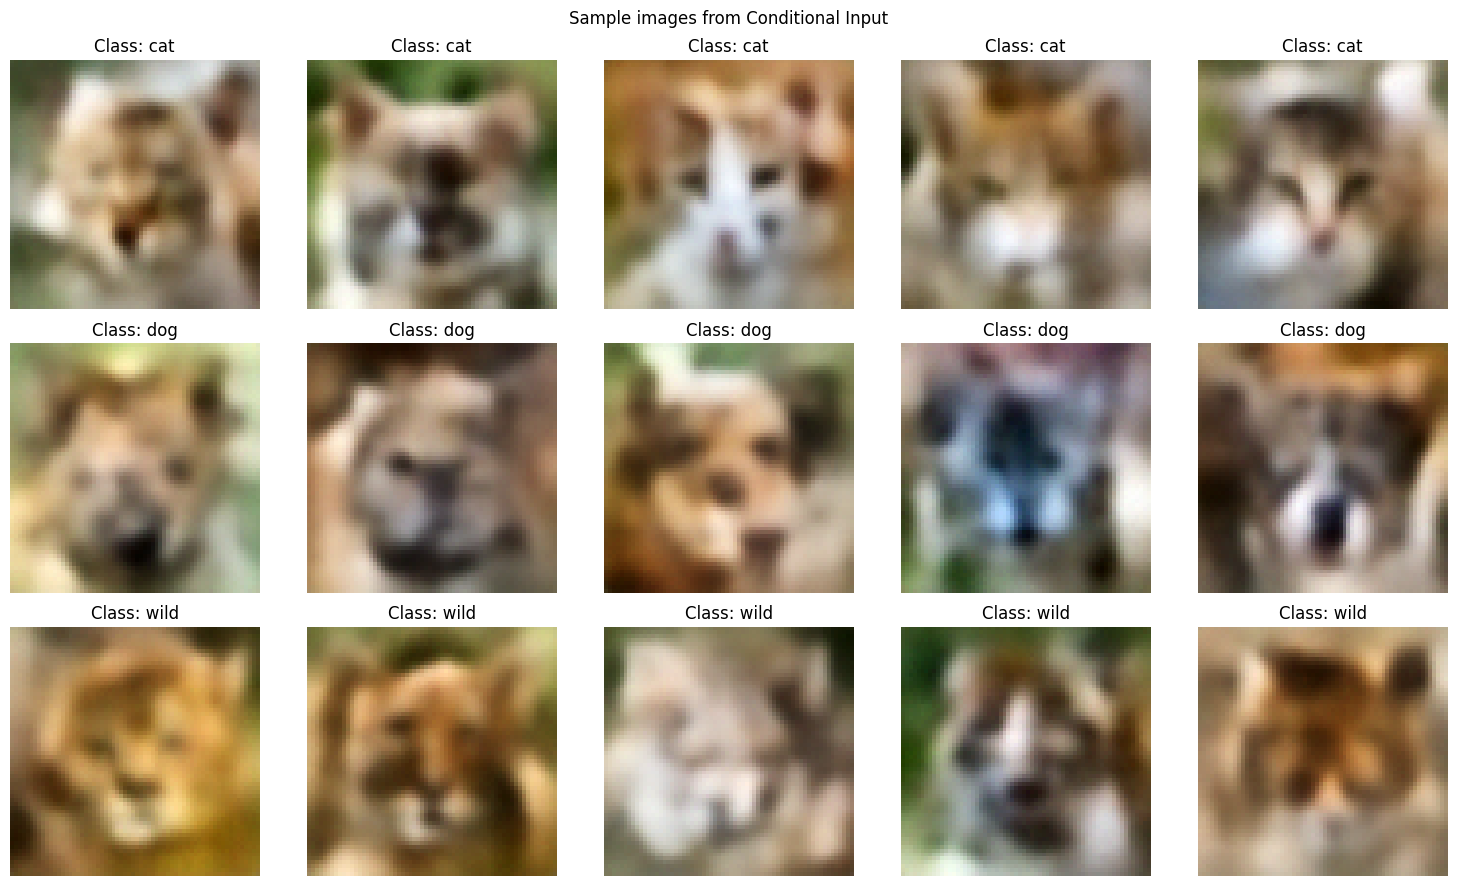

In [81]:
model.to(device)
visualize_reconstructions(model, device, val_loader)

#### <font color='red'>2. Model with kl_weight=0.1</font>

In [82]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=0.1

num_epochs=40

latent_dim = 512 # define latent dimension

name=f"Conditional_kl_{str(kl_weight)}_ep_{num_epochs}_bottleneck_{latent_dim}"
project="assignment-5-v2"


# Load model
model = ConditionalVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

Training Name: Conditional_kl_0.1_ep_40_bottleneck_512
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 0.1



  2%|██                                                                                  | 1/40 [00:09<05:59,  9.21s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 1249.3368, Recon: 1198.3992, KL: 509.3754
Eval  - Total: 768.3129, Recon: 706.8081, KL: 615.0477


  5%|████▏                                                                               | 2/40 [00:18<05:49,  9.21s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 690.7553, Recon: 627.9452, KL: 628.1016
Eval  - Total: 587.8027, Recon: 521.9998, KL: 658.0283


  8%|██████▎                                                                             | 3/40 [00:27<05:39,  9.17s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 585.9233, Recon: 518.0107, KL: 679.1259
Eval  - Total: 533.4840, Recon: 465.6808, KL: 678.0311


 10%|████████▍                                                                           | 4/40 [00:36<05:29,  9.16s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 541.1441, Recon: 470.5590, KL: 705.8517
Eval  - Total: 485.6863, Recon: 415.5639, KL: 701.2232


 12%|██████████▌                                                                         | 5/40 [00:45<05:20,  9.15s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 513.2481, Recon: 440.8182, KL: 724.2992
Eval  - Total: 467.8700, Recon: 395.1328, KL: 727.3718


 15%|████████████▌                                                                       | 6/40 [00:54<05:10,  9.13s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 481.4134, Recon: 408.3694, KL: 730.4397
Eval  - Total: 448.4765, Recon: 374.8760, KL: 736.0054


 18%|██████████████▋                                                                     | 7/40 [01:04<05:00,  9.12s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 461.8227, Recon: 387.8251, KL: 739.9762
Eval  - Total: 447.1708, Recon: 374.4917, KL: 726.7915


 20%|████████████████▊                                                                   | 8/40 [01:13<04:51,  9.12s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 440.9706, Recon: 366.5402, KL: 744.3037
Eval  - Total: 404.2858, Recon: 328.7195, KL: 755.6630


 22%|██████████████████▉                                                                 | 9/40 [01:22<04:42,  9.11s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 427.7952, Recon: 352.9677, KL: 748.2749
Eval  - Total: 390.5708, Recon: 316.2306, KL: 743.4015


 25%|████████████████████▊                                                              | 10/40 [01:31<04:33,  9.11s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 417.5430, Recon: 342.6110, KL: 749.3206
Eval  - Total: 382.8736, Recon: 308.8333, KL: 740.4032


 28%|██████████████████████▊                                                            | 11/40 [01:40<04:24,  9.12s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 392.0752, Recon: 318.0744, KL: 740.0073
Eval  - Total: 357.0278, Recon: 285.0133, KL: 720.1453


 30%|████████████████████████▉                                                          | 12/40 [01:49<04:15,  9.14s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 383.5752, Recon: 309.9906, KL: 735.8461
Eval  - Total: 349.5621, Recon: 277.8243, KL: 717.3777


 32%|██████████████████████████▉                                                        | 13/40 [01:58<04:06,  9.13s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 377.5207, Recon: 303.9218, KL: 735.9887
Eval  - Total: 356.6592, Recon: 283.9605, KL: 726.9877


 35%|█████████████████████████████                                                      | 14/40 [02:07<03:57,  9.13s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 373.4278, Recon: 299.7827, KL: 736.4514
Eval  - Total: 343.8861, Recon: 271.1492, KL: 727.3689


 38%|███████████████████████████████▏                                                   | 15/40 [02:17<03:48,  9.13s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 369.5941, Recon: 295.6734, KL: 739.2072
Eval  - Total: 347.6518, Recon: 274.3182, KL: 733.3359


 40%|█████████████████████████████████▏                                                 | 16/40 [02:26<03:39,  9.13s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 362.6179, Recon: 288.6296, KL: 739.8832
Eval  - Total: 333.3041, Recon: 259.7824, KL: 735.2163


 42%|███████████████████████████████████▎                                               | 17/40 [02:35<03:29,  9.11s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 359.5153, Recon: 285.2643, KL: 742.5102
Eval  - Total: 325.3461, Recon: 252.6283, KL: 727.1778


 45%|█████████████████████████████████████▎                                             | 18/40 [02:44<03:21,  9.15s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 354.4362, Recon: 280.1922, KL: 742.4393
Eval  - Total: 324.2759, Recon: 251.4619, KL: 728.1396


 48%|███████████████████████████████████████▍                                           | 19/40 [02:53<03:12,  9.19s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 351.6195, Recon: 277.1440, KL: 744.7554
Eval  - Total: 329.3800, Recon: 256.0220, KL: 733.5807


 50%|█████████████████████████████████████████▌                                         | 20/40 [03:02<03:04,  9.20s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 347.1445, Recon: 272.5676, KL: 745.7698
Eval  - Total: 325.8277, Recon: 251.9062, KL: 739.2145


 52%|███████████████████████████████████████████▌                                       | 21/40 [03:12<02:54,  9.21s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 336.3705, Recon: 262.0162, KL: 743.5420
Eval  - Total: 310.3932, Recon: 237.5556, KL: 728.3757


 55%|█████████████████████████████████████████████▋                                     | 22/40 [03:21<02:45,  9.21s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 331.7941, Recon: 257.5434, KL: 742.5068
Eval  - Total: 306.6131, Recon: 233.3681, KL: 732.4495


 57%|███████████████████████████████████████████████▋                                   | 23/40 [03:30<02:36,  9.21s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 331.1544, Recon: 256.8747, KL: 742.7973
Eval  - Total: 303.7608, Recon: 230.4222, KL: 733.3862


 60%|█████████████████████████████████████████████████▊                                 | 24/40 [03:39<02:27,  9.23s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 328.6848, Recon: 254.3112, KL: 743.7360
Eval  - Total: 306.9997, Recon: 234.1566, KL: 728.4304


 62%|███████████████████████████████████████████████████▉                               | 25/40 [03:49<02:18,  9.23s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 327.5912, Recon: 253.2464, KL: 743.4473
Eval  - Total: 304.5788, Recon: 231.4920, KL: 730.8681


 65%|█████████████████████████████████████████████████████▉                             | 26/40 [03:58<02:09,  9.28s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 324.9885, Recon: 250.5936, KL: 743.9491
Eval  - Total: 302.8512, Recon: 230.0342, KL: 728.1703


 68%|████████████████████████████████████████████████████████                           | 27/40 [04:07<02:00,  9.27s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 322.3648, Recon: 247.8937, KL: 744.7112
Eval  - Total: 301.4438, Recon: 227.8138, KL: 736.3000


 70%|██████████████████████████████████████████████████████████                         | 28/40 [04:17<01:51,  9.29s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 320.8398, Recon: 246.2961, KL: 745.4368
Eval  - Total: 300.2965, Recon: 226.1308, KL: 741.6568


 72%|████████████████████████████████████████████████████████████▏                      | 29/40 [04:26<01:42,  9.28s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 319.1763, Recon: 244.5972, KL: 745.7917
Eval  - Total: 299.5297, Recon: 225.5542, KL: 739.7541


 75%|██████████████████████████████████████████████████████████████▎                    | 30/40 [04:35<01:32,  9.27s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 316.9555, Recon: 242.4265, KL: 745.2900
Eval  - Total: 294.4089, Recon: 221.5297, KL: 728.7921


 78%|████████████████████████████████████████████████████████████████▎                  | 31/40 [04:44<01:23,  9.26s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 312.1395, Recon: 237.5187, KL: 746.2083
Eval  - Total: 289.6241, Recon: 216.0720, KL: 735.5210


 80%|██████████████████████████████████████████████████████████████████▍                | 32/40 [04:54<01:13,  9.25s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 310.6145, Recon: 236.0323, KL: 745.8218
Eval  - Total: 290.9611, Recon: 216.2512, KL: 747.0985


 82%|████████████████████████████████████████████████████████████████████▍              | 33/40 [05:03<01:04,  9.23s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 309.8811, Recon: 235.2473, KL: 746.3380
Eval  - Total: 289.8924, Recon: 216.5527, KL: 733.3975


 85%|██████████████████████████████████████████████████████████████████████▌            | 34/40 [05:12<00:55,  9.21s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 307.7599, Recon: 233.1337, KL: 746.2613
Eval  - Total: 290.8020, Recon: 216.9552, KL: 738.4686


 88%|████████████████████████████████████████████████████████████████████████▋          | 35/40 [05:21<00:46,  9.24s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 307.0152, Recon: 232.3408, KL: 746.7437
Eval  - Total: 288.8857, Recon: 215.0509, KL: 738.3476


 90%|██████████████████████████████████████████████████████████████████████████▋        | 36/40 [05:30<00:36,  9.21s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 306.0783, Recon: 231.4786, KL: 745.9967
Eval  - Total: 288.7869, Recon: 215.6008, KL: 731.8613


 92%|████████████████████████████████████████████████████████████████████████████▊      | 37/40 [05:40<00:27,  9.20s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 305.2650, Recon: 230.6149, KL: 746.5009
Eval  - Total: 287.1408, Recon: 213.5389, KL: 736.0184


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 38/40 [05:49<00:18,  9.17s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 303.6550, Recon: 228.9485, KL: 747.0652
Eval  - Total: 286.9643, Recon: 213.4836, KL: 734.8068


 98%|████████████████████████████████████████████████████████████████████████████████▉  | 39/40 [05:58<00:09,  9.16s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 304.8363, Recon: 230.1140, KL: 747.2225
Eval  - Total: 287.5579, Recon: 213.8745, KL: 736.8341


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [06:07<00:00,  9.18s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 303.3068, Recon: 228.4904, KL: 748.1638
Eval  - Total: 285.7774, Recon: 212.0867, KL: 736.9072


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████████▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/kl_loss,▁▄▆▇▇▇██████████████████████████████████
train/recon_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/kl_loss,▁▃▄▅▇▇▇█▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇
val/recon_loss,█▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
learning_rate,1e-05
train/kl_loss,748.16379


Model saved at: ./saved_models/Conditional_kl_0.1_ep_40_bottleneck_512


In [83]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_2147475/2494337095.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model Conditional_kl_0.1_ep_40_bottleneck_512: 119.55596923828125


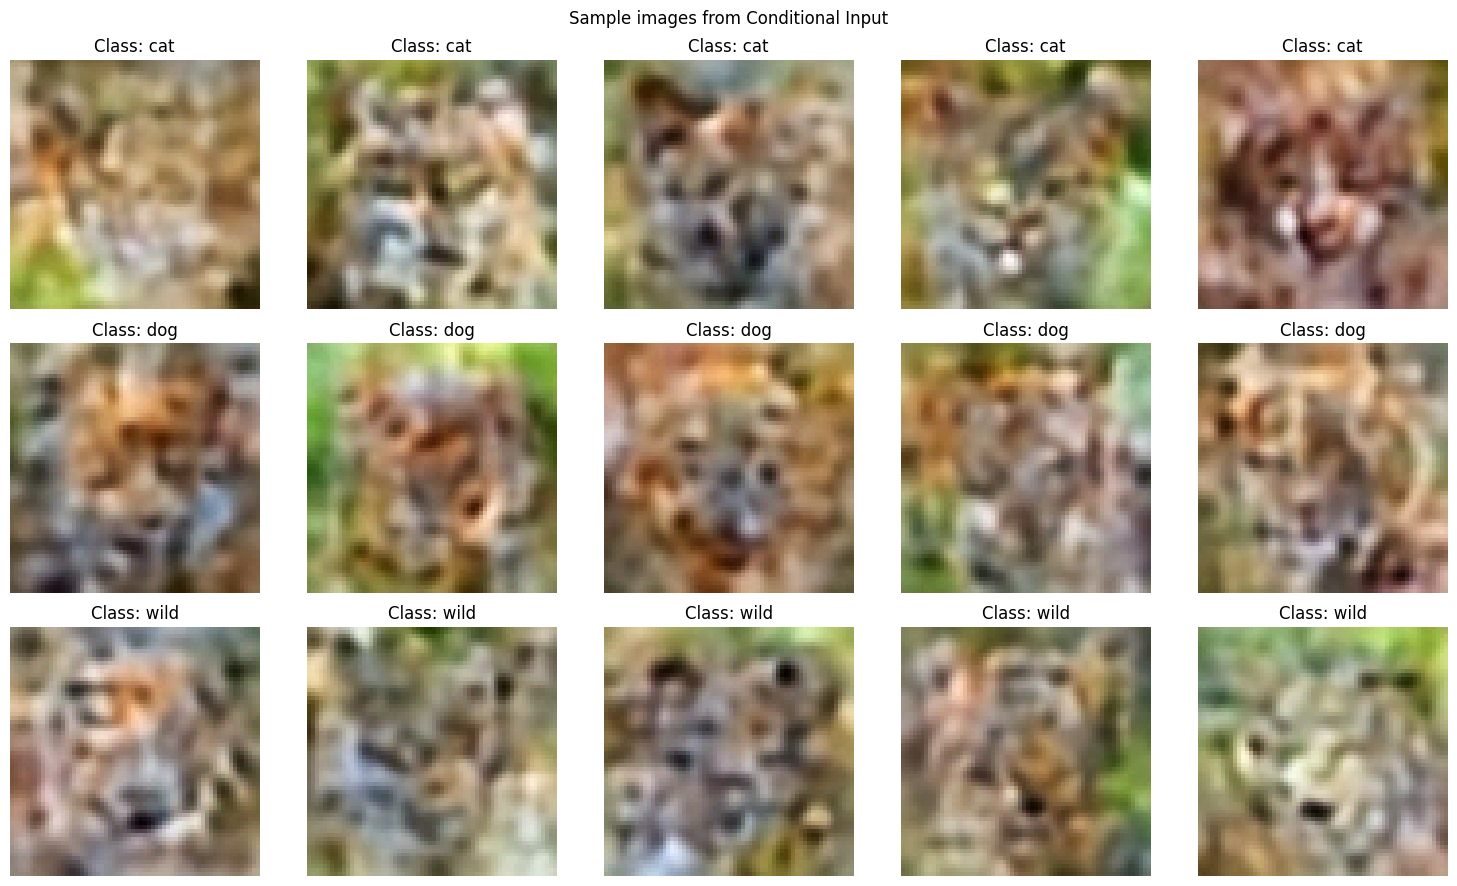

In [84]:
model.to(device)
visualize_reconstructions(model, device, val_loader)

#### <font color='red'>3. Model with kl_weight=0.01</font>

In [85]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=0.01

num_epochs=40

latent_dim = 512 # define latent dimension

name=f"Conditional_kl_{str(kl_weight)}_ep_{num_epochs}_bottleneck_{latent_dim}"
project="assignment-5-v2"


# Load model
model = ConditionalVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

Training Name: Conditional_kl_0.01_ep_40_bottleneck_512
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 0.01



  2%|██                                                                                  | 1/40 [00:09<06:00,  9.25s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 2204.6019, Recon: 1349.1761, KL: 85542.5785
Eval  - Total: 869.8615, Recon: 857.9946, KL: 1186.6910


  5%|████▏                                                                               | 2/40 [00:18<05:53,  9.31s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 754.3728, Recon: 742.0192, KL: 1235.3664
Eval  - Total: 643.4726, Recon: 631.0703, KL: 1240.2255


  8%|██████▎                                                                             | 3/40 [00:27<05:42,  9.25s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 617.3381, Recon: 604.2388, KL: 1309.9225
Eval  - Total: 556.2105, Recon: 542.8026, KL: 1340.7882


 10%|████████▍                                                                           | 4/40 [00:36<05:31,  9.22s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 547.6568, Recon: 533.7227, KL: 1393.4078
Eval  - Total: 497.9202, Recon: 483.7450, KL: 1417.5248


 12%|██████████▌                                                                         | 5/40 [00:46<05:23,  9.25s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 492.7923, Recon: 478.3746, KL: 1441.7731
Eval  - Total: 455.7358, Recon: 441.4646, KL: 1427.1204


 15%|████████████▌                                                                       | 6/40 [00:55<05:14,  9.26s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 454.7374, Recon: 439.8202, KL: 1491.7153
Eval  - Total: 420.4996, Recon: 405.4707, KL: 1502.8865


 18%|██████████████▋                                                                     | 7/40 [01:04<05:06,  9.28s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 420.0595, Recon: 404.6931, KL: 1536.6348
Eval  - Total: 404.2121, Recon: 389.0838, KL: 1512.8382


 20%|████████████████▊                                                                   | 8/40 [01:14<04:57,  9.29s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 392.9563, Recon: 377.1282, KL: 1582.8028
Eval  - Total: 374.3648, Recon: 358.5878, KL: 1577.6954


 22%|██████████████████▉                                                                 | 9/40 [01:23<04:46,  9.25s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 369.9277, Recon: 353.8238, KL: 1610.3894
Eval  - Total: 359.5471, Recon: 343.6446, KL: 1590.2499


 25%|████████████████████▊                                                              | 10/40 [01:32<04:37,  9.26s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 355.1988, Recon: 338.7537, KL: 1644.5099
Eval  - Total: 346.4987, Recon: 329.9329, KL: 1656.5788


 28%|██████████████████████▊                                                            | 11/40 [01:41<04:27,  9.23s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 332.1078, Recon: 315.5783, KL: 1652.9425
Eval  - Total: 330.1266, Recon: 313.8801, KL: 1624.6448


 30%|████████████████████████▉                                                          | 12/40 [01:51<04:19,  9.28s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 322.3697, Recon: 305.9740, KL: 1639.5650
Eval  - Total: 319.7102, Recon: 303.5690, KL: 1614.1168


 32%|██████████████████████████▉                                                        | 13/40 [02:00<04:10,  9.29s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 314.9628, Recon: 298.5783, KL: 1638.4487
Eval  - Total: 314.1258, Recon: 297.9375, KL: 1618.8285


 35%|█████████████████████████████                                                      | 14/40 [02:09<04:01,  9.29s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 308.0727, Recon: 291.6931, KL: 1637.9541
Eval  - Total: 307.5604, Recon: 291.4228, KL: 1613.7624


 38%|███████████████████████████████▏                                                   | 15/40 [02:19<03:51,  9.28s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 301.5612, Recon: 285.2027, KL: 1635.8448
Eval  - Total: 311.1398, Recon: 295.2789, KL: 1586.0903


 40%|█████████████████████████████████▏                                                 | 16/40 [02:28<03:42,  9.28s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 294.7683, Recon: 278.3796, KL: 1638.8753
Eval  - Total: 303.0355, Recon: 286.7575, KL: 1627.8064


 42%|███████████████████████████████████▎                                               | 17/40 [02:37<03:33,  9.28s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 290.1776, Recon: 273.7439, KL: 1643.3646
Eval  - Total: 297.4280, Recon: 281.2643, KL: 1616.3761


 45%|█████████████████████████████████████▎                                             | 18/40 [02:46<03:24,  9.29s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 285.4441, Recon: 268.9393, KL: 1650.4813
Eval  - Total: 296.1505, Recon: 279.8171, KL: 1633.3406


 48%|███████████████████████████████████████▍                                           | 19/40 [02:56<03:14,  9.28s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 280.3521, Recon: 263.7872, KL: 1656.4936
Eval  - Total: 288.3304, Recon: 271.9847, KL: 1634.5717


 50%|█████████████████████████████████████████▌                                         | 20/40 [03:05<03:05,  9.27s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 272.3128, Recon: 255.6896, KL: 1662.3129
Eval  - Total: 285.3382, Recon: 269.2107, KL: 1612.7450


 52%|███████████████████████████████████████████▌                                       | 21/40 [03:14<02:55,  9.24s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 262.1974, Recon: 245.6249, KL: 1657.2534
Eval  - Total: 279.0884, Recon: 262.9734, KL: 1611.5027


 55%|█████████████████████████████████████████████▋                                     | 22/40 [03:23<02:46,  9.24s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 261.4388, Recon: 244.9116, KL: 1652.7169
Eval  - Total: 279.7350, Recon: 263.5448, KL: 1619.0215


 57%|███████████████████████████████████████████████▋                                   | 23/40 [03:33<02:37,  9.25s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 257.1706, Recon: 240.6833, KL: 1648.7285
Eval  - Total: 274.6970, Recon: 258.5879, KL: 1610.9070


 60%|█████████████████████████████████████████████████▊                                 | 24/40 [03:42<02:28,  9.26s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 253.5228, Recon: 237.0654, KL: 1645.7433
Eval  - Total: 271.4775, Recon: 255.4128, KL: 1606.4674


 62%|███████████████████████████████████████████████████▉                               | 25/40 [03:51<02:18,  9.26s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 253.6808, Recon: 237.2461, KL: 1643.4694
Eval  - Total: 272.7118, Recon: 256.4949, KL: 1621.6962


 65%|█████████████████████████████████████████████████████▉                             | 26/40 [04:00<02:09,  9.23s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 249.8464, Recon: 233.4139, KL: 1643.2447
Eval  - Total: 269.4659, Recon: 253.1878, KL: 1627.8092


 68%|████████████████████████████████████████████████████████                           | 27/40 [04:10<02:00,  9.29s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 247.6140, Recon: 231.1884, KL: 1642.5664
Eval  - Total: 270.0187, Recon: 253.8772, KL: 1614.1487


 70%|██████████████████████████████████████████████████████████                         | 28/40 [04:19<01:51,  9.27s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 244.3146, Recon: 227.9040, KL: 1641.0537
Eval  - Total: 270.3058, Recon: 254.2708, KL: 1603.5015


 72%|████████████████████████████████████████████████████████████▏                      | 29/40 [04:28<01:41,  9.27s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 244.3756, Recon: 227.9861, KL: 1638.9419
Eval  - Total: 272.6403, Recon: 256.7159, KL: 1592.4370


 75%|██████████████████████████████████████████████████████████████▎                    | 30/40 [04:37<01:32,  9.26s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 241.5644, Recon: 225.1757, KL: 1638.8723
Eval  - Total: 266.8475, Recon: 250.7681, KL: 1607.9453


 78%|████████████████████████████████████████████████████████████████▎                  | 31/40 [04:47<01:23,  9.25s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 235.6843, Recon: 219.2848, KL: 1639.9470
Eval  - Total: 262.5682, Recon: 246.4117, KL: 1615.6474


 80%|██████████████████████████████████████████████████████████████████▍                | 32/40 [04:56<01:13,  9.23s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 233.1342, Recon: 216.7825, KL: 1635.1740
Eval  - Total: 259.4760, Recon: 243.6530, KL: 1582.3017


 82%|████████████████████████████████████████████████████████████████████▍              | 33/40 [05:05<01:04,  9.22s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 232.3419, Recon: 215.9939, KL: 1634.7941
Eval  - Total: 257.7061, Recon: 241.7375, KL: 1596.8553


 85%|██████████████████████████████████████████████████████████████████████▌            | 34/40 [05:14<00:55,  9.23s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 231.1994, Recon: 214.8868, KL: 1631.2601
Eval  - Total: 260.1532, Recon: 244.0792, KL: 1607.3918


 88%|████████████████████████████████████████████████████████████████████████▋          | 35/40 [05:24<00:46,  9.24s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 229.7579, Recon: 213.4521, KL: 1630.5805
Eval  - Total: 258.6762, Recon: 242.8290, KL: 1584.7142


 90%|██████████████████████████████████████████████████████████████████████████▋        | 36/40 [05:33<00:36,  9.24s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 228.5151, Recon: 212.2215, KL: 1629.3663
Eval  - Total: 256.3150, Recon: 240.4174, KL: 1589.7641


 92%|████████████████████████████████████████████████████████████████████████████▊      | 37/40 [05:42<00:27,  9.25s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 228.4471, Recon: 212.1642, KL: 1628.2902
Eval  - Total: 257.1026, Recon: 241.1352, KL: 1596.7475


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 38/40 [05:51<00:18,  9.29s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 227.1261, Recon: 210.8551, KL: 1627.1008
Eval  - Total: 256.9622, Recon: 240.8376, KL: 1612.4610


 98%|████████████████████████████████████████████████████████████████████████████████▉  | 39/40 [06:01<00:09,  9.29s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 225.3094, Recon: 209.0487, KL: 1626.0708
Eval  - Total: 253.5282, Recon: 237.5466, KL: 1598.1629


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [06:10<00:00,  9.26s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 224.0380, Recon: 207.7787, KL: 1625.9311
Eval  - Total: 254.1971, Recon: 238.0798, KL: 1611.7329


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████████▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/kl_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/recon_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/kl_loss,▁▂▃▄▅▆▆▇▇██▇▇▇▇█▇██▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val/recon_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
learning_rate,1e-05
train/kl_loss,1625.9311


Model saved at: ./saved_models/Conditional_kl_0.01_ep_40_bottleneck_512


In [86]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_2147475/2494337095.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model Conditional_kl_0.01_ep_40_bottleneck_512: 118.5216293334961


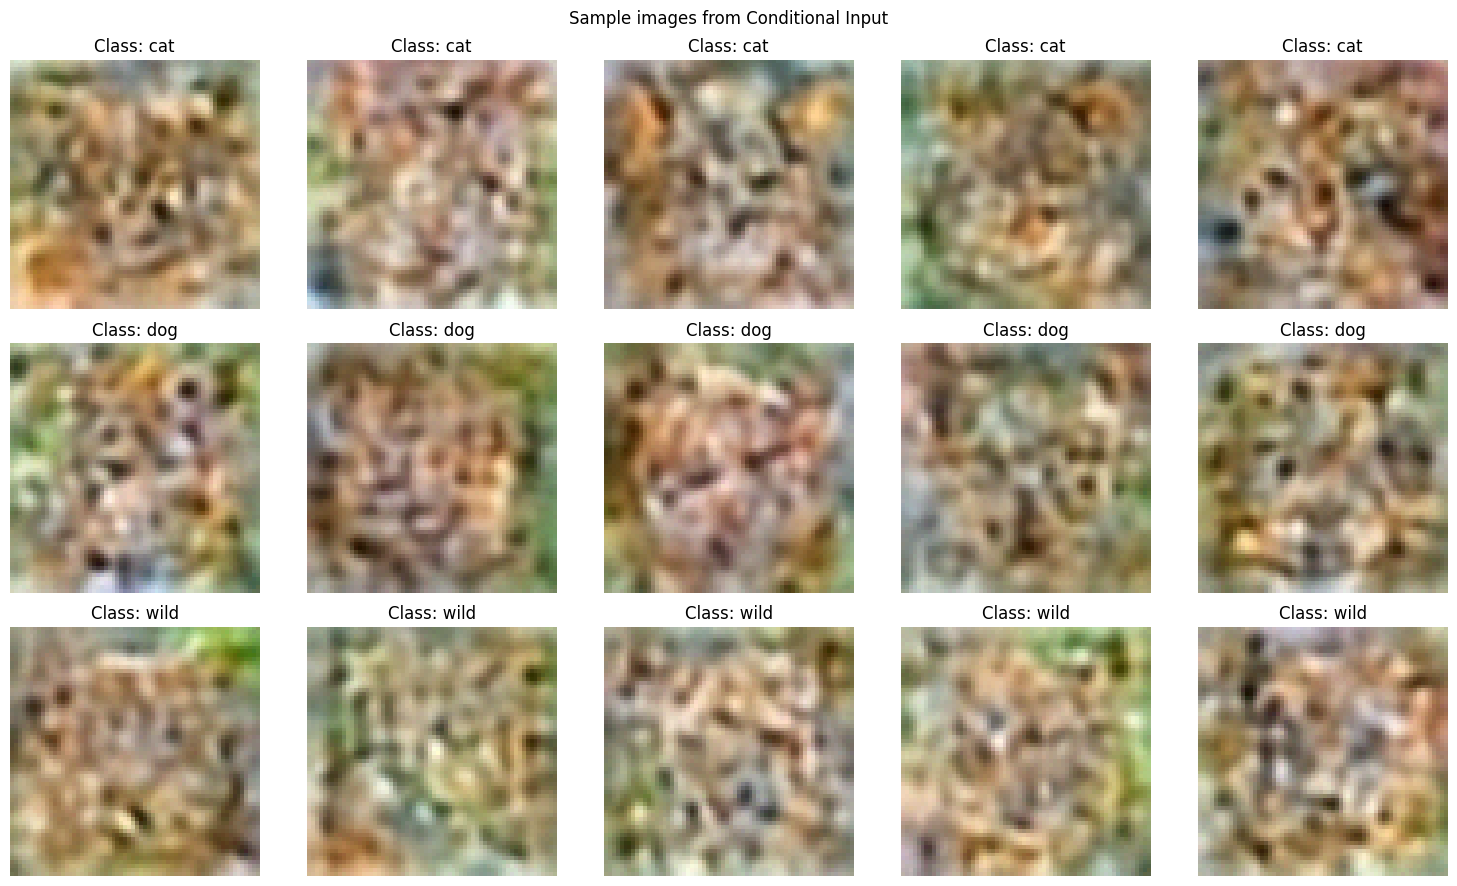

In [87]:
model.to(device)
visualize_reconstructions(model, device, val_loader)

#### <font color='red'>4. Model with kl_weight=0.001</font>

In [88]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=0.001

num_epochs=40

latent_dim = 512 # define latent dimension

name=f"Conditional_kl_{str(kl_weight)}_ep_{num_epochs}_bottleneck_{latent_dim}"
project="assignment-5-v2"


# Load model
model = ConditionalVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

Training Name: Conditional_kl_0.001_ep_40_bottleneck_512
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 0.001



  2%|██                                                                                  | 1/40 [00:09<06:05,  9.38s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 1260.7392, Recon: 1258.2966, KL: 2442.6163
Eval  - Total: 759.1784, Recon: 757.2379, KL: 1940.4776


  5%|████▏                                                                               | 2/40 [00:18<05:54,  9.33s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 637.4533, Recon: 635.1650, KL: 2288.3419
Eval  - Total: 537.8616, Recon: 535.6010, KL: 2260.5451


  8%|██████▎                                                                             | 3/40 [00:27<05:42,  9.26s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 503.1086, Recon: 500.5578, KL: 2550.8486
Eval  - Total: 458.0155, Recon: 455.3608, KL: 2654.7193


 10%|████████▍                                                                           | 4/40 [00:37<05:33,  9.26s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 442.1554, Recon: 439.4368, KL: 2718.6077
Eval  - Total: 415.5200, Recon: 412.7604, KL: 2759.6465


 12%|██████████▌                                                                         | 5/40 [00:46<05:23,  9.25s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 401.3050, Recon: 398.4649, KL: 2840.1144
Eval  - Total: 381.9966, Recon: 379.0663, KL: 2930.2835


 15%|████████████▌                                                                       | 6/40 [00:55<05:14,  9.25s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 374.5464, Recon: 371.5784, KL: 2968.0372
Eval  - Total: 352.4107, Recon: 349.3442, KL: 3066.4917


 18%|██████████████▋                                                                     | 7/40 [01:05<05:06,  9.30s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 349.8465, Recon: 346.7743, KL: 3072.2449
Eval  - Total: 333.1772, Recon: 330.0802, KL: 3096.9503


 20%|████████████████▊                                                                   | 8/40 [01:14<04:57,  9.31s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 329.1222, Recon: 325.9740, KL: 3148.1609
Eval  - Total: 325.6260, Recon: 322.4037, KL: 3222.3518


 22%|██████████████████▉                                                                 | 9/40 [01:23<04:47,  9.27s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 312.9993, Recon: 309.7861, KL: 3213.1761
Eval  - Total: 291.5765, Recon: 288.3377, KL: 3238.8623


 25%|████████████████████▊                                                              | 10/40 [01:32<04:38,  9.28s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 301.4270, Recon: 298.1498, KL: 3277.1468
Eval  - Total: 288.1138, Recon: 284.8176, KL: 3296.2436


 28%|██████████████████████▊                                                            | 11/40 [01:42<04:29,  9.29s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 278.9912, Recon: 275.6510, KL: 3340.1950
Eval  - Total: 266.3452, Recon: 263.0153, KL: 3329.9039


 30%|████████████████████████▉                                                          | 12/40 [01:51<04:19,  9.28s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 272.4252, Recon: 269.1012, KL: 3324.0051
Eval  - Total: 269.0588, Recon: 265.7297, KL: 3329.0784


 32%|██████████████████████████▉                                                        | 13/40 [02:00<04:11,  9.30s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 267.1633, Recon: 263.8639, KL: 3299.3731
Eval  - Total: 255.4229, Recon: 252.2367, KL: 3186.2330


 35%|█████████████████████████████                                                      | 14/40 [02:09<04:01,  9.28s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 261.9671, Recon: 258.6847, KL: 3282.3626
Eval  - Total: 253.4387, Recon: 250.2393, KL: 3199.3228


 38%|███████████████████████████████▏                                                   | 15/40 [02:19<03:51,  9.24s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 257.3717, Recon: 254.0968, KL: 3274.9612
Eval  - Total: 254.3489, Recon: 251.1280, KL: 3220.8764


 40%|█████████████████████████████████▏                                                 | 16/40 [02:28<03:43,  9.31s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 250.7515, Recon: 247.4884, KL: 3263.1676
Eval  - Total: 243.6501, Recon: 240.4045, KL: 3245.5220


 42%|███████████████████████████████████▎                                               | 17/40 [02:37<03:34,  9.32s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 246.4391, Recon: 243.1728, KL: 3266.2833
Eval  - Total: 256.5620, Recon: 253.2787, KL: 3283.3013


 45%|█████████████████████████████████████▎                                             | 18/40 [02:47<03:23,  9.27s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 243.8360, Recon: 240.5691, KL: 3266.8948
Eval  - Total: 235.9969, Recon: 232.7595, KL: 3237.4662


 48%|███████████████████████████████████████▍                                           | 19/40 [02:56<03:14,  9.26s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 238.7977, Recon: 235.5327, KL: 3264.9670
Eval  - Total: 238.1654, Recon: 234.9501, KL: 3215.2413


 50%|█████████████████████████████████████████▌                                         | 20/40 [03:05<03:04,  9.25s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 234.8736, Recon: 231.6029, KL: 3270.7202
Eval  - Total: 229.6785, Recon: 226.3802, KL: 3298.3156


 52%|███████████████████████████████████████████▌                                       | 21/40 [03:14<02:55,  9.22s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 224.8815, Recon: 221.5933, KL: 3288.2071
Eval  - Total: 221.5844, Recon: 218.2821, KL: 3302.2880


 55%|█████████████████████████████████████████████▋                                     | 22/40 [03:23<02:45,  9.20s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 220.8735, Recon: 217.5946, KL: 3278.8707
Eval  - Total: 218.3905, Recon: 215.1657, KL: 3224.8399


 57%|███████████████████████████████████████████████▋                                   | 23/40 [03:33<02:36,  9.21s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 219.2745, Recon: 216.0100, KL: 3264.4742
Eval  - Total: 215.9711, Recon: 212.7390, KL: 3232.1661


 60%|█████████████████████████████████████████████████▊                                 | 24/40 [03:42<02:27,  9.20s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 218.1883, Recon: 214.9357, KL: 3252.5445
Eval  - Total: 215.0436, Recon: 211.8457, KL: 3197.8964


 62%|███████████████████████████████████████████████████▉                               | 25/40 [03:51<02:18,  9.26s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 216.5331, Recon: 213.2951, KL: 3238.0264
Eval  - Total: 216.3383, Recon: 213.1107, KL: 3227.5996


 65%|█████████████████████████████████████████████████████▉                             | 26/40 [04:00<02:09,  9.25s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 213.4945, Recon: 210.2668, KL: 3227.7070
Eval  - Total: 211.8022, Recon: 208.6674, KL: 3134.8149


 68%|████████████████████████████████████████████████████████                           | 27/40 [04:10<02:00,  9.25s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 211.0824, Recon: 207.8645, KL: 3217.9197
Eval  - Total: 209.9386, Recon: 206.7675, KL: 3171.0186


 70%|██████████████████████████████████████████████████████████                         | 28/40 [04:19<01:50,  9.25s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 210.4727, Recon: 207.2651, KL: 3207.6363
Eval  - Total: 208.7371, Recon: 205.5932, KL: 3143.8959


 72%|████████████████████████████████████████████████████████████▏                      | 29/40 [04:28<01:41,  9.24s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 207.3681, Recon: 204.1710, KL: 3197.1232
Eval  - Total: 209.1105, Recon: 205.9149, KL: 3195.6120


 75%|██████████████████████████████████████████████████████████████▎                    | 30/40 [04:37<01:32,  9.22s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 205.6610, Recon: 202.4744, KL: 3186.5701
Eval  - Total: 207.1521, Recon: 203.9231, KL: 3229.0493


 78%|████████████████████████████████████████████████████████████████▎                  | 31/40 [04:47<01:23,  9.25s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 200.6082, Recon: 197.4148, KL: 3193.4591
Eval  - Total: 201.9604, Recon: 198.8353, KL: 3125.1095


 80%|██████████████████████████████████████████████████████████████████▍                | 32/40 [04:56<01:14,  9.30s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 199.4774, Recon: 196.2893, KL: 3188.1044
Eval  - Total: 202.4906, Recon: 199.3431, KL: 3147.4578


 82%|████████████████████████████████████████████████████████████████████▍              | 33/40 [05:05<01:04,  9.25s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 198.5462, Recon: 195.3636, KL: 3182.5696
Eval  - Total: 202.2837, Recon: 199.1322, KL: 3151.5498


 85%|██████████████████████████████████████████████████████████████████████▌            | 34/40 [05:14<00:55,  9.26s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 197.7701, Recon: 194.5949, KL: 3175.1822
Eval  - Total: 200.6716, Recon: 197.5210, KL: 3150.5841


 88%|████████████████████████████████████████████████████████████████████████▋          | 35/40 [05:24<00:46,  9.26s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 196.5731, Recon: 193.4047, KL: 3168.3832
Eval  - Total: 199.7658, Recon: 196.6441, KL: 3121.7573


 90%|██████████████████████████████████████████████████████████████████████████▋        | 36/40 [05:33<00:37,  9.25s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 195.9157, Recon: 192.7556, KL: 3160.0650
Eval  - Total: 199.5266, Recon: 196.3529, KL: 3173.6947


 92%|████████████████████████████████████████████████████████████████████████████▊      | 37/40 [05:42<00:27,  9.26s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 194.2018, Recon: 191.0480, KL: 3153.7967
Eval  - Total: 197.6257, Recon: 194.5673, KL: 3058.4113


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 38/40 [05:51<00:18,  9.25s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 194.1459, Recon: 191.0001, KL: 3145.7859
Eval  - Total: 198.1016, Recon: 195.0123, KL: 3089.2375


 98%|████████████████████████████████████████████████████████████████████████████████▉  | 39/40 [06:01<00:09,  9.24s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 192.5145, Recon: 189.3743, KL: 3140.1678
Eval  - Total: 197.3247, Recon: 194.2344, KL: 3090.2616


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [06:10<00:00,  9.26s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 191.6430, Recon: 188.5090, KL: 3134.0291
Eval  - Total: 196.7795, Recon: 193.6906, KL: 3088.9509


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████████▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/kl_loss,▂▁▃▄▅▆▆▇▇██████▇██▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
train/recon_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/kl_loss,▁▃▅▅▆▇▇▇████▇▇▇███▇██▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val/recon_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
learning_rate,1e-05
train/kl_loss,3134.02906


Model saved at: ./saved_models/Conditional_kl_0.001_ep_40_bottleneck_512


In [89]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_2147475/2494337095.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model Conditional_kl_0.001_ep_40_bottleneck_512: 117.24026489257812


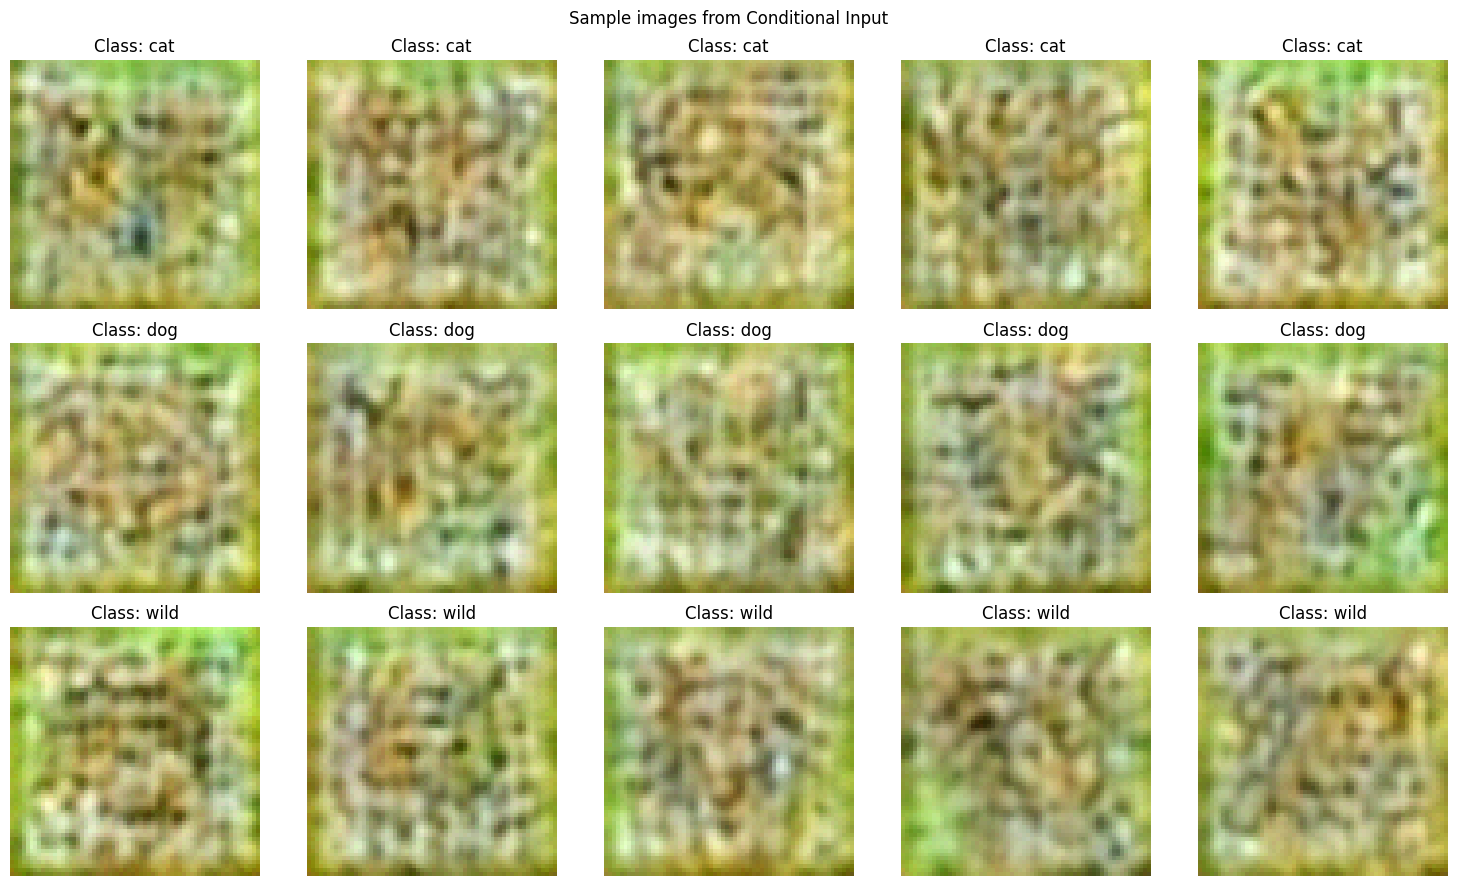

In [90]:
model.to(device)
visualize_reconstructions(model, device, val_loader)

#### <font color='red'>5. Model with kl_weight=1.5</font>

In [91]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=1.5

num_epochs=40

latent_dim = 512 # define latent dimension

name=f"Conditional_kl_{str(kl_weight)}_ep_{num_epochs}_bottleneck_{latent_dim}"
project="assignment-5-v2"


# Load model
model = ConditionalVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

Training Name: Conditional_kl_1.5_ep_40_bottleneck_512
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 1.5



  2%|██                                                                                  | 1/40 [00:09<05:56,  9.15s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 1600.8932, Recon: 1428.4207, KL: 114.9817
Eval  - Total: 1667.6701, Recon: 1497.3894, KL: 113.5204


  5%|████▏                                                                               | 2/40 [00:18<05:53,  9.31s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 1170.5197, Recon: 975.9026, KL: 129.7447
Eval  - Total: 1174.4674, Recon: 975.0447, KL: 132.9485


  8%|██████▎                                                                             | 3/40 [00:28<05:59,  9.72s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 1055.9916, Recon: 848.9105, KL: 138.0540
Eval  - Total: 1035.6192, Recon: 821.9610, KL: 142.4388


 10%|████████▍                                                                           | 4/40 [00:38<05:44,  9.56s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 994.5387, Recon: 785.2361, KL: 139.5351
Eval  - Total: 933.6001, Recon: 706.5704, KL: 151.3531


 12%|██████████▌                                                                         | 5/40 [00:47<05:30,  9.45s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 946.8442, Recon: 741.2085, KL: 137.0905
Eval  - Total: 881.1256, Recon: 691.9533, KL: 126.1148


 15%|████████████▌                                                                       | 6/40 [00:56<05:20,  9.43s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 910.8035, Recon: 709.9811, KL: 133.8816
Eval  - Total: 774.5785, Recon: 584.1845, KL: 126.9293


 18%|██████████████▋                                                                     | 7/40 [01:06<05:10,  9.42s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 877.4816, Recon: 680.7450, KL: 131.1577
Eval  - Total: 782.0306, Recon: 591.1395, KL: 127.2608


 20%|████████████████▊                                                                   | 8/40 [01:15<05:00,  9.40s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 855.2176, Recon: 661.9124, KL: 128.8702
Eval  - Total: 741.4177, Recon: 555.6500, KL: 123.8451


 22%|██████████████████▉                                                                 | 9/40 [01:24<04:51,  9.41s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 831.9476, Recon: 641.7101, KL: 126.8250
Eval  - Total: 718.1534, Recon: 527.8142, KL: 126.8928


 25%|████████████████████▊                                                              | 10/40 [01:34<04:41,  9.37s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 816.0918, Recon: 627.4787, KL: 125.7421
Eval  - Total: 700.7397, Recon: 519.2950, KL: 120.9631


 28%|██████████████████████▊                                                            | 11/40 [01:43<04:31,  9.36s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 785.7014, Recon: 602.1834, KL: 122.3453
Eval  - Total: 668.6622, Recon: 494.3223, KL: 116.2266


 30%|████████████████████████▉                                                          | 12/40 [01:52<04:21,  9.34s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 775.6773, Recon: 592.5906, KL: 122.0577
Eval  - Total: 680.7950, Recon: 507.2482, KL: 115.6979


 32%|██████████████████████████▉                                                        | 13/40 [02:02<04:11,  9.33s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 767.7389, Recon: 583.7639, KL: 122.6500
Eval  - Total: 690.3070, Recon: 512.4517, KL: 118.5702


 35%|█████████████████████████████                                                      | 14/40 [02:11<04:02,  9.33s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 758.9450, Recon: 575.2994, KL: 122.4304
Eval  - Total: 678.2688, Recon: 506.6253, KL: 114.4290


 38%|███████████████████████████████▏                                                   | 15/40 [02:20<03:52,  9.32s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 751.1268, Recon: 567.3483, KL: 122.5190
Eval  - Total: 664.7218, Recon: 487.9774, KL: 117.8296


 40%|█████████████████████████████████▏                                                 | 16/40 [02:30<03:44,  9.36s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 746.8741, Recon: 562.7212, KL: 122.7686
Eval  - Total: 653.2175, Recon: 473.5000, KL: 119.8116


 42%|███████████████████████████████████▎                                               | 17/40 [02:39<03:34,  9.34s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 743.1858, Recon: 558.2635, KL: 123.2816
Eval  - Total: 640.8178, Recon: 462.7232, KL: 118.7297


 45%|█████████████████████████████████████▎                                             | 18/40 [02:48<03:25,  9.34s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 735.5942, Recon: 551.0316, KL: 123.0417
Eval  - Total: 645.1131, Recon: 469.1469, KL: 117.3108


 48%|███████████████████████████████████████▍                                           | 19/40 [02:58<03:14,  9.28s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 730.9961, Recon: 545.6903, KL: 123.5372
Eval  - Total: 646.4816, Recon: 467.9295, KL: 119.0347


 50%|█████████████████████████████████████████▌                                         | 20/40 [03:07<03:05,  9.29s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 725.6515, Recon: 540.3902, KL: 123.5075
Eval  - Total: 614.6780, Recon: 439.5936, KL: 116.7229


 52%|███████████████████████████████████████████▌                                       | 21/40 [03:16<02:57,  9.35s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 713.4290, Recon: 528.9523, KL: 122.9845
Eval  - Total: 625.1721, Recon: 443.9005, KL: 120.8477


 55%|█████████████████████████████████████████████▋                                     | 22/40 [03:26<02:48,  9.36s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 710.6972, Recon: 526.9980, KL: 122.4661
Eval  - Total: 614.5430, Recon: 438.4606, KL: 117.3883


 57%|███████████████████████████████████████████████▋                                   | 23/40 [03:35<02:39,  9.36s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 707.3697, Recon: 523.0278, KL: 122.8946
Eval  - Total: 615.5708, Recon: 438.0390, KL: 118.3545


 60%|█████████████████████████████████████████████████▊                                 | 24/40 [03:44<02:29,  9.34s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 705.5487, Recon: 521.0887, KL: 122.9733
Eval  - Total: 606.3481, Recon: 427.8586, KL: 118.9930


 62%|███████████████████████████████████████████████████▉                               | 25/40 [03:54<02:19,  9.32s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 703.4664, Recon: 518.7937, KL: 123.1152
Eval  - Total: 607.9315, Recon: 429.2392, KL: 119.1282


 65%|█████████████████████████████████████████████████████▉                             | 26/40 [04:03<02:10,  9.31s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 701.3893, Recon: 516.5758, KL: 123.2090
Eval  - Total: 609.2114, Recon: 432.3313, KL: 117.9201


 68%|████████████████████████████████████████████████████████                           | 27/40 [04:12<02:01,  9.31s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 699.5207, Recon: 514.2097, KL: 123.5407
Eval  - Total: 596.9716, Recon: 420.8419, KL: 117.4198


 70%|██████████████████████████████████████████████████████████                         | 28/40 [04:22<01:52,  9.34s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 696.8392, Recon: 511.4707, KL: 123.5790
Eval  - Total: 601.2097, Recon: 422.8675, KL: 118.8948


 72%|████████████████████████████████████████████████████████████▏                      | 29/40 [04:31<01:42,  9.35s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 693.7136, Recon: 508.1406, KL: 123.7153
Eval  - Total: 601.3857, Recon: 421.6902, KL: 119.7970


 75%|██████████████████████████████████████████████████████████████▎                    | 30/40 [04:40<01:33,  9.36s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 691.0180, Recon: 505.3961, KL: 123.7479
Eval  - Total: 602.7710, Recon: 424.8192, KL: 118.6345


 78%|████████████████████████████████████████████████████████████████▎                  | 31/40 [04:50<01:24,  9.35s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 688.2712, Recon: 502.7816, KL: 123.6597
Eval  - Total: 592.8132, Recon: 416.3428, KL: 117.6469


 80%|██████████████████████████████████████████████████████████████████▍                | 32/40 [04:59<01:14,  9.33s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 684.7178, Recon: 499.5423, KL: 123.4503
Eval  - Total: 591.2573, Recon: 413.2050, KL: 118.7016


 82%|████████████████████████████████████████████████████████████████████▍              | 33/40 [05:08<01:05,  9.32s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 683.9716, Recon: 498.6025, KL: 123.5794
Eval  - Total: 589.6018, Recon: 409.8057, KL: 119.8641


 85%|██████████████████████████████████████████████████████████████████████▌            | 34/40 [05:18<00:55,  9.31s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 682.6142, Recon: 496.9561, KL: 123.7721
Eval  - Total: 594.0034, Recon: 415.5452, KL: 118.9722


 88%|████████████████████████████████████████████████████████████████████████▋          | 35/40 [05:27<00:46,  9.33s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 680.9705, Recon: 495.1467, KL: 123.8826
Eval  - Total: 588.7199, Recon: 407.3118, KL: 120.9388


 90%|██████████████████████████████████████████████████████████████████████████▋        | 36/40 [05:36<00:37,  9.32s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 680.8105, Recon: 495.0015, KL: 123.8727
Eval  - Total: 590.5469, Recon: 409.0515, KL: 120.9969


 92%|████████████████████████████████████████████████████████████████████████████▊      | 37/40 [05:46<00:27,  9.33s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 680.4786, Recon: 494.5801, KL: 123.9323
Eval  - Total: 588.0502, Recon: 408.8886, KL: 119.4410


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 38/40 [05:55<00:18,  9.32s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 679.2112, Recon: 493.3021, KL: 123.9394
Eval  - Total: 594.7769, Recon: 413.5690, KL: 120.8053


 98%|████████████████████████████████████████████████████████████████████████████████▉  | 39/40 [06:04<00:09,  9.34s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 678.9012, Recon: 492.7362, KL: 124.1100
Eval  - Total: 593.9608, Recon: 414.5964, KL: 119.5763


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [06:14<00:00,  9.35s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 677.1437, Recon: 490.6348, KL: 124.3393
Eval  - Total: 593.9910, Recon: 413.4428, KL: 120.3655


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████████▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/kl_loss,▁▅██▇▆▆▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄
train/recon_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/kl_loss,▁▅▆█▃▃▄▃▃▂▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val/recon_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
learning_rate,1e-05
train/kl_loss,124.33928


Model saved at: ./saved_models/Conditional_kl_1.5_ep_40_bottleneck_512


In [92]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_2147475/2494337095.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model Conditional_kl_1.5_ep_40_bottleneck_512: 146.9676971435547


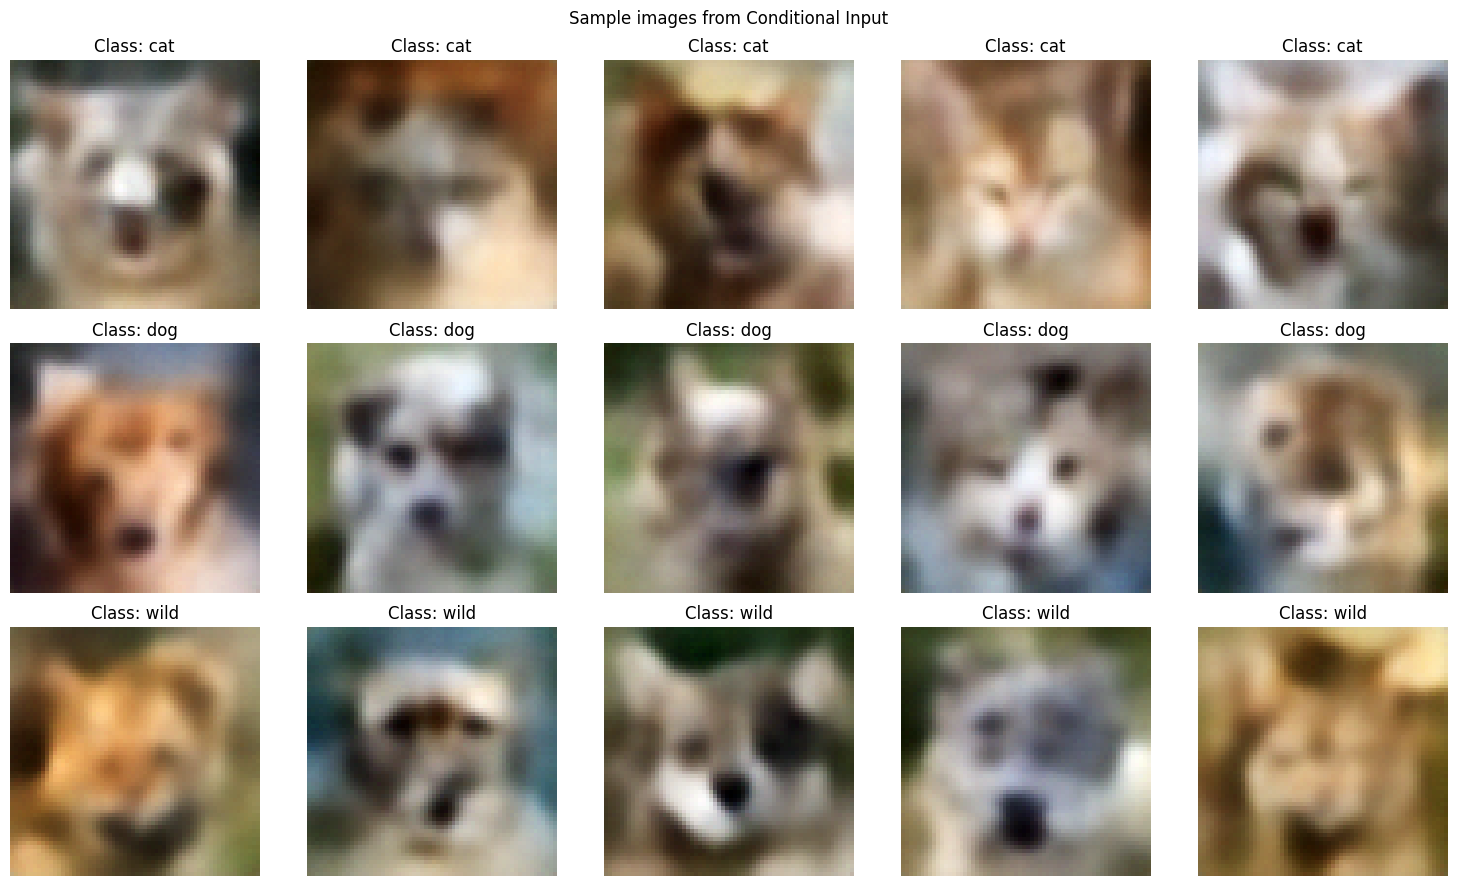

In [93]:
model.to(device)
visualize_reconstructions(model, device, val_loader)

#### <font color='red'>6. Model with kl_weight=2</font>

In [94]:
# Model training parameters
learning_rate=0.0001
step_size=10
gamma=0.5

kl_weight=2.0

num_epochs=40

latent_dim = 512 # define latent dimension

name=f"Conditional_kl_{str(kl_weight)}_ep_{num_epochs}_bottleneck_{latent_dim}"
project="assignment-5-v2"


# Load model
model = ConditionalVAE(latent_dim=latent_dim).to(device)
# model

model = run_vae_training(
    model, train_loader, val_loader, device, 
    num_epochs=num_epochs, learning_rate=learning_rate,
    step_size=step_size, gamma=gamma,
    kl_weight=kl_weight,
    name=name, project=project
)

save_path = os.path.join(saved_model_folder, name)
torch.save(model, save_path)
print(f"Model saved at: {save_path}")

Training Name: Conditional_kl_2.0_ep_40_bottleneck_512
Total num. of Epochs: 40
Learning Rate: 0.0001
KL Weight used for Loss function: 2.0



  2%|██                                                                                  | 1/40 [00:09<06:03,  9.33s/it]


Epoch 1/40
Learning Rate: 0.000100
Train - Total: 1684.6078, Recon: 1509.1455, KL: 87.7312
Eval  - Total: 1963.9549, Recon: 1775.6222, KL: 94.1663


  5%|████▏                                                                               | 2/40 [00:18<05:53,  9.31s/it]


Epoch 2/40
Learning Rate: 0.000100
Train - Total: 1239.4166, Recon: 1031.0011, KL: 104.2077
Eval  - Total: 1251.5628, Recon: 1028.9362, KL: 111.3133


  8%|██████▎                                                                             | 3/40 [00:27<05:43,  9.29s/it]


Epoch 3/40
Learning Rate: 0.000100
Train - Total: 1135.4600, Recon: 912.4124, KL: 111.5238
Eval  - Total: 1087.3678, Recon: 868.4542, KL: 109.4568


 10%|████████▍                                                                           | 4/40 [00:37<05:34,  9.30s/it]


Epoch 4/40
Learning Rate: 0.000100
Train - Total: 1069.9475, Recon: 846.0769, KL: 111.9353
Eval  - Total: 989.2883, Recon: 781.6771, KL: 103.8056


 12%|██████████▌                                                                         | 5/40 [00:46<05:24,  9.29s/it]


Epoch 5/40
Learning Rate: 0.000100
Train - Total: 1019.9750, Recon: 801.5955, KL: 109.1897
Eval  - Total: 891.1192, Recon: 685.3941, KL: 102.8625


 15%|████████████▌                                                                       | 6/40 [00:55<05:15,  9.28s/it]


Epoch 6/40
Learning Rate: 0.000100
Train - Total: 977.6493, Recon: 764.3649, KL: 106.6422
Eval  - Total: 874.7458, Recon: 666.5438, KL: 104.1010


 18%|██████████████▋                                                                     | 7/40 [01:05<05:06,  9.30s/it]


Epoch 7/40
Learning Rate: 0.000100
Train - Total: 945.1993, Recon: 735.5247, KL: 104.8373
Eval  - Total: 809.8766, Recon: 614.4021, KL: 97.7372


 20%|████████████████▊                                                                   | 8/40 [01:14<04:57,  9.30s/it]


Epoch 8/40
Learning Rate: 0.000100
Train - Total: 920.0667, Recon: 713.7663, KL: 103.1502
Eval  - Total: 825.9705, Recon: 608.0527, KL: 108.9589


 22%|██████████████████▉                                                                 | 9/40 [01:23<04:48,  9.30s/it]


Epoch 9/40
Learning Rate: 0.000100
Train - Total: 900.8872, Recon: 696.4115, KL: 102.2379
Eval  - Total: 792.1167, Recon: 597.0629, KL: 97.5269


 25%|████████████████████▊                                                              | 10/40 [01:32<04:38,  9.29s/it]


Epoch 10/40
Learning Rate: 0.000100
Train - Total: 881.0795, Recon: 677.8238, KL: 101.6278
Eval  - Total: 807.6598, Recon: 603.2139, KL: 102.2230


 28%|██████████████████████▊                                                            | 11/40 [01:42<04:29,  9.30s/it]


Epoch 11/40
Learning Rate: 0.000050
Train - Total: 849.2035, Recon: 652.1008, KL: 98.5513
Eval  - Total: 743.3929, Recon: 556.2686, KL: 93.5621


 30%|████████████████████████▉                                                          | 12/40 [01:51<04:20,  9.30s/it]


Epoch 12/40
Learning Rate: 0.000050
Train - Total: 837.8763, Recon: 640.9382, KL: 98.4690
Eval  - Total: 739.9946, Recon: 552.5311, KL: 93.7317


 32%|██████████████████████████▉                                                        | 13/40 [02:00<04:10,  9.29s/it]


Epoch 13/40
Learning Rate: 0.000050
Train - Total: 831.8268, Recon: 634.5264, KL: 98.6502
Eval  - Total: 749.4826, Recon: 556.8804, KL: 96.3011


 35%|█████████████████████████████                                                      | 14/40 [02:10<04:01,  9.28s/it]


Epoch 14/40
Learning Rate: 0.000050
Train - Total: 824.4236, Recon: 627.0984, KL: 98.6626
Eval  - Total: 734.0843, Recon: 546.4296, KL: 93.8273


 38%|███████████████████████████████▏                                                   | 15/40 [02:19<03:52,  9.30s/it]


Epoch 15/40
Learning Rate: 0.000050
Train - Total: 818.9290, Recon: 620.9126, KL: 99.0082
Eval  - Total: 755.6338, Recon: 562.7668, KL: 96.4335


 40%|█████████████████████████████████▏                                                 | 16/40 [02:28<03:42,  9.28s/it]


Epoch 16/40
Learning Rate: 0.000050
Train - Total: 811.4287, Recon: 612.6706, KL: 99.3790
Eval  - Total: 751.3000, Recon: 554.9964, KL: 98.1518


 42%|███████████████████████████████████▎                                               | 17/40 [02:38<03:33,  9.30s/it]


Epoch 17/40
Learning Rate: 0.000050
Train - Total: 804.5453, Recon: 605.2139, KL: 99.6657
Eval  - Total: 723.1240, Recon: 528.6957, KL: 97.2141


 45%|█████████████████████████████████████▎                                             | 18/40 [02:47<03:24,  9.29s/it]


Epoch 18/40
Learning Rate: 0.000050
Train - Total: 799.3908, Recon: 599.9416, KL: 99.7246
Eval  - Total: 716.9636, Recon: 521.7799, KL: 97.5919


 48%|███████████████████████████████████████▍                                           | 19/40 [02:56<03:15,  9.29s/it]


Epoch 19/40
Learning Rate: 0.000050
Train - Total: 793.0477, Recon: 592.9572, KL: 100.0452
Eval  - Total: 710.5615, Recon: 514.9125, KL: 97.8245


 50%|█████████████████████████████████████████▌                                         | 20/40 [03:05<03:05,  9.27s/it]


Epoch 20/40
Learning Rate: 0.000050
Train - Total: 790.0539, Recon: 589.6468, KL: 100.2035
Eval  - Total: 704.3890, Recon: 509.4934, KL: 97.4478


 52%|███████████████████████████████████████████▌                                       | 21/40 [03:15<02:56,  9.29s/it]


Epoch 21/40
Learning Rate: 0.000025
Train - Total: 777.5665, Recon: 578.7084, KL: 99.4290
Eval  - Total: 683.9997, Recon: 493.5613, KL: 95.2192


 55%|█████████████████████████████████████████████▋                                     | 22/40 [03:24<02:47,  9.32s/it]


Epoch 22/40
Learning Rate: 0.000025
Train - Total: 771.7614, Recon: 573.1461, KL: 99.3076
Eval  - Total: 674.2770, Recon: 485.5730, KL: 94.3520


 57%|███████████████████████████████████████████████▋                                   | 23/40 [03:33<02:38,  9.31s/it]


Epoch 23/40
Learning Rate: 0.000025
Train - Total: 770.2043, Recon: 571.0859, KL: 99.5592
Eval  - Total: 673.9206, Recon: 480.7767, KL: 96.5720


 60%|█████████████████████████████████████████████████▊                                 | 24/40 [03:43<02:29,  9.32s/it]


Epoch 24/40
Learning Rate: 0.000025
Train - Total: 767.3514, Recon: 567.9073, KL: 99.7221
Eval  - Total: 667.2339, Recon: 477.1055, KL: 95.0642


 62%|███████████████████████████████████████████████████▉                               | 25/40 [03:52<02:19,  9.32s/it]


Epoch 25/40
Learning Rate: 0.000025
Train - Total: 765.8636, Recon: 566.0967, KL: 99.8834
Eval  - Total: 683.8526, Recon: 490.6410, KL: 96.6058


 65%|█████████████████████████████████████████████████████▉                             | 26/40 [04:01<02:10,  9.32s/it]


Epoch 26/40
Learning Rate: 0.000025
Train - Total: 763.4959, Recon: 563.3687, KL: 100.0636
Eval  - Total: 684.7035, Recon: 489.4985, KL: 97.6025


 68%|████████████████████████████████████████████████████████                           | 27/40 [04:11<02:01,  9.31s/it]


Epoch 27/40
Learning Rate: 0.000025
Train - Total: 762.7928, Recon: 562.4035, KL: 100.1946
Eval  - Total: 659.4750, Recon: 467.5624, KL: 95.9563


 70%|██████████████████████████████████████████████████████████                         | 28/40 [04:20<01:51,  9.29s/it]


Epoch 28/40
Learning Rate: 0.000025
Train - Total: 760.2837, Recon: 559.8844, KL: 100.1996
Eval  - Total: 667.2739, Recon: 473.7890, KL: 96.7425


 72%|████████████████████████████████████████████████████████████▏                      | 29/40 [04:29<01:42,  9.30s/it]


Epoch 29/40
Learning Rate: 0.000025
Train - Total: 757.6064, Recon: 556.8339, KL: 100.3862
Eval  - Total: 660.0457, Recon: 469.9718, KL: 95.0370


 75%|██████████████████████████████████████████████████████████████▎                    | 30/40 [04:39<01:33,  9.33s/it]


Epoch 30/40
Learning Rate: 0.000025
Train - Total: 755.3002, Recon: 554.2133, KL: 100.5434
Eval  - Total: 656.5642, Recon: 463.6485, KL: 96.4579


 78%|████████████████████████████████████████████████████████████████▎                  | 31/40 [04:48<01:23,  9.31s/it]


Epoch 31/40
Learning Rate: 0.000013
Train - Total: 750.2396, Recon: 549.7082, KL: 100.2657
Eval  - Total: 654.0412, Recon: 459.0978, KL: 97.4717


 80%|██████████████████████████████████████████████████████████████████▍                | 32/40 [04:57<01:14,  9.31s/it]


Epoch 32/40
Learning Rate: 0.000013
Train - Total: 748.1613, Recon: 547.8830, KL: 100.1392
Eval  - Total: 652.6519, Recon: 458.6539, KL: 96.9990


 82%|████████████████████████████████████████████████████████████████████▍              | 33/40 [05:06<01:05,  9.31s/it]


Epoch 33/40
Learning Rate: 0.000013
Train - Total: 746.6852, Recon: 546.0119, KL: 100.3366
Eval  - Total: 647.9680, Recon: 456.1892, KL: 95.8894


 85%|██████████████████████████████████████████████████████████████████████▌            | 34/40 [05:16<00:55,  9.30s/it]


Epoch 34/40
Learning Rate: 0.000013
Train - Total: 744.5266, Recon: 543.9074, KL: 100.3096
Eval  - Total: 652.7111, Recon: 461.0329, KL: 95.8391


 88%|████████████████████████████████████████████████████████████████████████▋          | 35/40 [05:25<00:46,  9.27s/it]


Epoch 35/40
Learning Rate: 0.000013
Train - Total: 744.6811, Recon: 543.8903, KL: 100.3954
Eval  - Total: 656.1752, Recon: 463.4785, KL: 96.3483


 90%|██████████████████████████████████████████████████████████████████████████▋        | 36/40 [05:34<00:37,  9.27s/it]


Epoch 36/40
Learning Rate: 0.000013
Train - Total: 744.1934, Recon: 542.8707, KL: 100.6614
Eval  - Total: 650.8389, Recon: 458.0484, KL: 96.3953


 92%|████████████████████████████████████████████████████████████████████████████▊      | 37/40 [05:44<00:27,  9.28s/it]


Epoch 37/40
Learning Rate: 0.000013
Train - Total: 743.5383, Recon: 542.3442, KL: 100.5970
Eval  - Total: 655.0749, Recon: 458.5271, KL: 98.2739


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 38/40 [05:53<00:18,  9.27s/it]


Epoch 38/40
Learning Rate: 0.000013
Train - Total: 741.6814, Recon: 540.1101, KL: 100.7856
Eval  - Total: 650.7924, Recon: 455.9682, KL: 97.4121


 98%|████████████████████████████████████████████████████████████████████████████████▉  | 39/40 [06:02<00:09,  9.27s/it]


Epoch 39/40
Learning Rate: 0.000013
Train - Total: 741.3390, Recon: 540.1408, KL: 100.5991
Eval  - Total: 645.4475, Recon: 452.9624, KL: 96.2425


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [06:11<00:00,  9.30s/it]


Epoch 40/40
Learning Rate: 0.000013
Train - Total: 739.6663, Recon: 537.9340, KL: 100.8661
Eval  - Total: 646.2258, Recon: 452.7014, KL: 96.7622


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████████▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/kl_loss,▁▆██▇▆▆▅▅▅▄▄▄▄▄▄▄▄▅▅▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
train/recon_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/kl_loss,▁█▇▅▅▅▃▇▃▄▁▁▂▁▂▃▂▃▃▃▂▁▂▂▂▃▂▂▂▂▃▂▂▂▂▂▃▃▂▂
val/recon_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
learning_rate,1e-05
train/kl_loss,100.86613


Model saved at: ./saved_models/Conditional_kl_2.0_ep_40_bottleneck_512


In [95]:
model = load_model(save_path)
max_samples = min(2000, len(val_loader.dataset))
fid_score = compute_fid_score(model, val_loader, device, max_samples=max_samples)
print(f"FID Score for model {name}: {fid_score}")

/tmp/ipykernel_2147475/2494337095.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


FID Score for model Conditional_kl_2.0_ep_40_bottleneck_512: 147.6467742919922


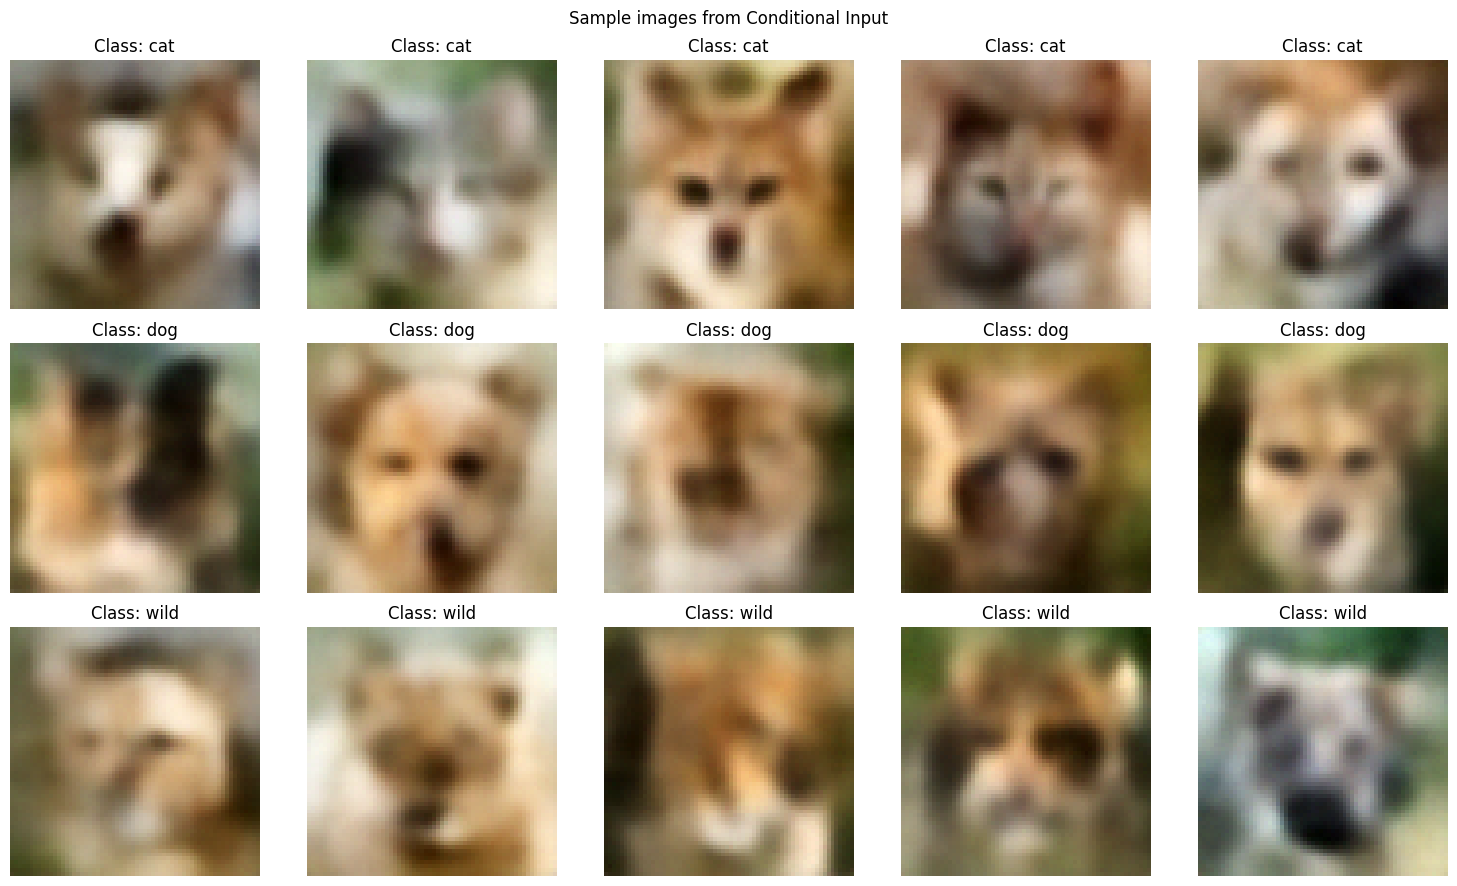

In [96]:
model.to(device)
visualize_reconstructions(model, device, val_loader)

## Observations:

- The best performance for Conditional Sampling is achieved when Kl-Weight is 1
- Going below one introduces noise, which increases as Kl-Weight decreases
- Going above makes the features overlap a bit too much between various classes

## Possible Explanation:

1) Due to the nature of the learning and reproduction task, an extensive Hyperparameter search is required to produce meaningful results.
2) We do not fully understand the reason behind the observed behaviour, but here is our hypothesis:
- As the KL-Weight decreases, the KL-loss starts to have a greater say in the reconstruction process which leads to more information being stored in the latent space.
- This leads to the conditional input not being able to provide the decoder with enough information to reconstruct the image, introducing noise.
- As the KL-Weight Increases, the latent-space stores less and less information about the image due to decreased KL-loss, which places a lot of "burden" on the conditional input to store meaningful image embeddings.
- However, since the conditional embedding is just a one hot vector there's only so much information that the Decoder can extract out of the conditional input. Which leads to the mix-up of features/blurred features.